# Install simpy :

In [1]:
!pip install simpy==4.0.1

# Import libraries :

In [2]:
import math
import simpy
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt

# Utilities

Extent the simpy.Container class to allow the container keep the user(for our case, the stations) who is requesting for the resource(vehivle in our case) in a list :

In [3]:
class MyContainer(simpy.Container):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stations = []

    def get(self, station, *args, **kwargs):
        self.stations.append(station)
        return super().get(*args, **kwargs)

    def put(self, station, *args, **kwargs,):
        self.stations.remove(station)
        return super().put(*args, **kwargs)

In [4]:
from collections import namedtuple

Vehicle = namedtuple('Vehicle', 'id, Container, status')

The functions for computing the mean and max waiting time: 

In [5]:
def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [6]:
def get_max_wait_time(wait_times):
    average_wait = max(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

# Debug flags

In [7]:
debug_sta = False # Debug log for station and depot station.
debug_pax = False # Debug log for passenger.
REFILL_FLAG = True # Refilling strategy switch
PATIENCE_FLAG = True # Patience strategy switch
SHOW_RESULT_FLAG = False # Show result switch

# Station :

* The bike-sharing staion with a capacity(maximum number of bikes/docks), init with init_ratio timesby capacity of bikes.
* The monitor process : when the bikes in the station(a container) <= capacity timesby reset_ratio or >= capacity timesby (1-reset_ratio), the calling of reset staion will triggered, the station will be reset with half number of capacity of bikes when the refilling vehicle arrived.

In [8]:
class Station(object):
    def __init__(self, env, id, depot_station, num_bikes, capacity, init_ratio, reset_ratio):
      self.env = env
      self.id = id
      self.bike = simpy.Container(env, init=num_bikes, capacity=capacity)
      self.mon_proc = env.process(self.monitor_proc(env))
      self.depot_station = depot_station
      self.calling_signal_start = self.env.event()
      self.calling_signal_start.succeed()
      self.capacity = capacity
      self.init_ratio = init_ratio
      self.reset_ratio = reset_ratio

    def get_bike(self, passenger):
        yield self.env.timeout(random.randint(1, 3))

    def put_bike(self, passenger):
        yield self.env.timeout(random.randint(1, 3))
  
    def reset_station(self):
        yield self.env.timeout(random.randint(5, 10))
        #if debug_sta : print(f'Station   [{self.id}] Repositioning vehicle arriving at :{self.env.now}, Current N.bikes : ({self.bike.level})')
        amount = math.ceil(self.bike.capacity//2 - self.bike.level)
        if amount > 0:  
          yield self.bike.put(amount)
          if debug_sta : print(f'Station   [{self.id}] Bikes filled at :{self.env.now} with amount {amount}, Current N.bikes : ({self.bike.level})')
        elif amount < 0:
          yield self.bike.get(abs(amount))
          if debug_sta : print(f'Station   [{self.id}] Bikes removed at :{self.env.now} with amount {abs(amount)}, Current N.bikes : ({self.bike.level})')
        else:
          if debug_sta : print(f'Station   [{self.id}] Bikes in station already balanced, Current N.bikes : ({self.bike.level})')

    def monitor_proc(self, env):
        while True:
          yield self.calling_signal_start
          if self.bike.level <= self.capacity*self.reset_ratio or self.bike.level >= self.capacity*(1-self.reset_ratio):
            self.calling_signal_start = self.env.event()
            #if debug_sta : print(f'Station [{self.id}] Calling repositioning vehicle at :{env.now}, Current N.bikes : ({self.bike.level})')
            try:
              #c_id, container, _ = self.depot_station.vehicle_store[random.choice([index for index, a_tuple in enumerate(self.depot_station.vehicle_store) if a_tuple.status == True])]
              c_id, container, _ = self.depot_station.vehicle_store[[index for index, a_tuple in enumerate(self.depot_station.vehicle_store) if a_tuple.status == True].pop()]
              if container.level <= container.capacity - self.depot_station.reset_threshold:
                self.depot_station.modify_activate(c_id, False)
              yield container.get(self, 1)
              if c_id:
                if debug_sta : print(f'Station [{self.id}] bikes: {self.bike.level}, Request a vehicle {c_id} at :{env.now}')
            except IndexError:
              pass
          yield self.env.timeout(1) # check the status every 10 minutes 

# Depot Station :

* The depot staion with capacity(num_vehicles), a vehicle is a container which has the ability to reset maximum half number stations.
* The monitor process : when a vehicle accumulate for capacity minus reset_threshold number of request for reset or the reset_delay divide delay_rate of time passed.(the delay rate is the rate for generating passengers in different period of time during the day timesby 0.5)

In [9]:
class Depot_Station(object):
  def __init__(self, env, num_vehicles, num_stations, reset_threshold, reset_delay):
        self.env = env
        self.vehicle_store = [Vehicle(id, MyContainer(env, init=num_stations//2, capacity=num_stations//2), True) for id in range(num_vehicles)]
        self.reset_threshold = reset_threshold
        for c_id in range(num_vehicles):
          self.mon_proc = env.process(self.monitor_proc(env, c_id))
        
  def count(self):
      v_count = 0
      for _, _, status in self.vehicle_store:
        if status: v_count += 1
      return v_count

  def modify_activate(self, c_id, status):
      id_vehicle = [index for index, a_tuple in enumerate(self.vehicle_store) if a_tuple.id == c_id].pop()
      vehicle = self.vehicle_store[id_vehicle]
      temp = list(vehicle)
      temp[2] = status
      self.vehicle_store[id_vehicle] = Vehicle._make(temp)

  def monitor_proc(self, env, con_id):
      global num_vehicles_in_use
      global repo_frequency
      global log_num_vehicles_in_use
      global log_repo_frequency
      vehicle_signal_start = self.env.event()

      while REFILL_FLAG:
        c_id, container, status = self.vehicle_store[[index for index, a_tuple in enumerate(self.vehicle_store) if a_tuple.id == con_id].pop()]
        if not status: vehicle_signal_start.succeed()

        # Delay rate will decrease during the day:
        if (5 <= self.env.now <= 11) or (15 <= self.env.now <= 21):
          delay_rate = peak_rate*0.5 # delay_rate = 2.5
        elif (11 < self.env.now < 15):
          delay_rate = noon_rate*0.5 # delay_rate = 1
        else:
          delay_rate = night_rate*0.5 # delay_rate = 0.5

        waiting_event = self.env.timeout(reset_delay//delay_rate)
        yield vehicle_signal_start | waiting_event
        vehicle_signal_start = self.env.event()

        if len(container.stations) > 0:
          num_vehicles_in_use = self.count()
          log_num_vehicles_in_use.append((self.env.now, num_vehicles_in_use))
          repo_frequency += 1
          log_repo_frequency.append((self.env.now, repo_frequency))
          if debug_sta : print(f'Depot Station assign a vehicle {c_id}, N.stations : {10 - container.level} at :{env.now}')
          self.modify_activate(c_id, False)
          if debug_sta : print(f"Reset stations: N.stations : {len(container.stations)}, level : {container.level}")
          stas = []
          for station in container.stations:
            stas.append(station)
          for station in stas:
            if debug_sta : print(f"{station.id}, sta_list : {[station.id for station in container.stations]}, stas_list : {[station.id for station in stas]}")
            yield self.env.process(station.reset_station())
            if debug_sta : print(f"Stations: [{station.id}] got reset at :{env.now}")
            yield container.put(station, 1)
            station.calling_signal_start.succeed()

          num_vehicles_in_use = self.count()
          log_num_vehicles_in_use.append((self.env.now, num_vehicles_in_use))
          self.modify_activate(c_id, True)
        yield self.env.timeout(1) # check the status every reset_delay minutes

# Passenger :

* The passengers (around 3720 with the current rate) will be generated with different rate in five periods(early-hours, morning, noon, evening, midnight) of a day, the time interval between consecutive passengers follows the exponential distributing.
* The passenger will run out of patience when waiting for a random number of minutes from 10 to 20 to get a bike and leave the station.
* The passenger will run out of patience when waiting for a random number of minutes from 20 to 30 to put a bike and then leave the station with the bike throwed away at the station.

In [10]:
class Passenger(object):
  def __init__(self, env, passenger_id, start_station, end_station):
    self.env = env
    self.passenger_id = passenger_id
    self.start_station = start_station
    self.end_station = end_station

  def go_to_station(self):
    global num_passengers_waiting
    global num_bike_in_use
    global num_impatiences_get
    global num_impatiences_put
    global log_num_passengers_waiting
    global log_num_bikes_in_use
    global log_wait_times
    global log_num_impatiences_get
    global log_num_impatiences_put

    # passenger arrives
    arrival_time = self.env.now

    # requring a bike
    if debug_pax : print(f"Passenger <{self.passenger_id}> starting requiring a bike at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
    request = self.start_station.bike.get(1)
    num_passengers_waiting += 1
    log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))

    if PATIENCE_FLAG:
      waiting_event = self.env.timeout(random.randrange(10,20))
      res = yield request | waiting_event
      if request in res:
        yield self.env.process(self.start_station.get_bike(self.passenger_id))
        num_bike_in_use += 1
        log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
        if debug_pax : print(f"Passenger <{self.passenger_id}> get a bike at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
        num_passengers_waiting -= 1
        log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
        # passenger leaves the station
        log_wait_times.append((self.env.now, self.env.now - arrival_time))
      else:
        request.cancel()
        if debug_pax : print(f"Passenger <{self.passenger_id}> run out of patience at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
        num_impatiences_get += 1
        log_num_impatiences_get.append((self.env.now, num_impatiences_get))
        num_passengers_waiting -= 1
        log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
        # passenger leaves the station
        log_wait_times.append((self.env.now, self.env.now - arrival_time))
        return
    else:
      yield request
      yield self.env.process(self.start_station.get_bike(self.passenger_id))
      num_bike_in_use += 1
      log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
      if debug_pax : print(f"Passenger <{self.passenger_id}> get a bike at :{self.env.now} on station [{self.start_station.id}], Current N.bikes : ({self.start_station.bike.level})")
      num_passengers_waiting -= 1
      log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
      # passenger leaves the station
      log_wait_times.append((self.env.now, self.env.now - arrival_time))

    # Taveling
    yield self.env.timeout(random.randint(10, 180))


    # passenger arrives
    arrival_time = self.env.now
    # putting a bike
    if debug_pax : print(f"Passenger <{self.passenger_id}> starting putting a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
    request = self.end_station.bike.put(1)
    #print(f"222 Passenger <{self.passenger_id}> starting putting a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
    num_passengers_waiting += 1
    log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))

    if PATIENCE_FLAG:
      waiting_event = self.env.timeout(random.randrange(20,30))
      res = yield request | waiting_event
      if request in res:
        yield self.env.process(self.end_station.put_bike(self.passenger_id))
        if debug_pax : print(f"Passenger <{self.passenger_id}> put a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
      else:
        request.cancel()
        if debug_pax : print(f"Passenger <{self.passenger_id}> run out of patience and throw away a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
        num_impatiences_put += 1
        log_num_impatiences_put.append((self.env.now, num_impatiences_put))
      # passenger leaves the station
      num_bike_in_use -= 1
      log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
      num_passengers_waiting -= 1
      log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
      log_wait_times.append((self.env.now, self.env.now - arrival_time))
    else:
      yield request
      yield self.env.process(self.end_station.put_bike(self.passenger_id))
      num_bike_in_use -= 1
      log_num_bikes_in_use.append((self.env.now, num_bike_in_use))
      if debug_pax : print(f"Passenger <{self.passenger_id}> put a bike at :{self.env.now} on station [{self.end_station.id}], Current N.bikes : ({self.end_station.bike.level})")
      num_passengers_waiting -= 1
      log_num_passengers_waiting.append((self.env.now, num_passengers_waiting))
      # passenger leaves the station
      log_wait_times.append((self.env.now, self.env.now - arrival_time))

# Main :

Start running the station for five perioids (early-hours, morning, noon, evening, midnight) with different rate for refilling and generate passgengers:

In [11]:
def run_station(env, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay):
  depot_station = Depot_Station(env, num_vehicles, num_stations, reset_threshold, reset_delay)
  stations = [Station(env, id, depot_station, math.ceil(capacity*init_ratio), capacity, init_ratio, reset_ratio) for id in range(num_stations)]
  day_splitting = {
      "early-hours" : (night_duration/2, night_rate),
      "morning" : (morning_duration, peak_rate),
      "noon" : (noon_duration, noon_rate),
      "evening" : (evening_duration, peak_rate),
      "midnight" : (night_duration/2, night_rate)
  }
  passenger_id = 0

  for _, (duration, rate) in day_splitting.items():
    period = 0
    while (period <= duration):
      start_station, end_station = random.choice(stations), random.choice(stations)
      pax = Passenger(env, passenger_id, start_station, end_station)
      env.process(pax.go_to_station())
      p = random.random()
      # Plug it into the inverse of the CDF of Exponential(_lamnbda)
      interval_arrival_time = -math.log(1.0 - p)/rate
      period += interval_arrival_time
      passenger_id += 1
      log_num_passengers.append((env.now, passenger_id))
      yield env.timeout(interval_arrival_time)

Run the environment.

In [12]:
def main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay):
  # Setup
  random.seed(42)

  # Run the simulation
  env = simpy.Environment()
  env.run(env.process(run_station(env, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)))

  # View the results
  avg_mins, avg_secs = get_average_wait_time(list(zip(*log_wait_times))[-1])
  max_mins, max_secs = get_max_wait_time(list(zip(*log_wait_times))[-1])
  if SHOW_RESULT_FLAG:
    print( "-------------------------------------------------------------------"
        f"\nRunning simulation {id} times ...",
        f"\nNum_vehicles: {num_vehicles}, Num_stations : {num_stations}, Capacity : {capacity}, Init_ratio : {init_ratio}, Reset_ratio : {reset_ratio}, Reset_threshold : {reset_threshold}, Reset_delay : {reset_delay}"
        f"\nFinished at time :{env.now}",
        f"\nThe average wait time is {avg_mins} minutes and {avg_secs} seconds.",
        f"\nThe max wait time is {max_mins} minutes and {max_secs} seconds.",
        f"\nRefilling frequency : {log_repo_frequency[-1][-1] if log_repo_frequency else 0}.",
        f"\nNum_impatiences_get : {log_num_impatiences_get[-1][-1] if log_num_impatiences_get else 0}.",
        f"\nNum_impatiences_put : {log_num_impatiences_put[-1][-1] if log_num_impatiences_put else 0}.",
        f"\nNum_passengers : {log_num_passengers[-1][-1] if log_num_passengers else 0}."
    )
  return avg_mins, avg_secs, max_mins, max_secs, log_repo_frequency[-1][-1] if log_repo_frequency else 0, log_num_impatiences_get[-1][-1] if log_num_impatiences_get else 0, log_num_impatiences_put[-1][-1] if log_num_impatiences_put else 0

# Parameters :

Grid search :
1. Number of total vehicles the depot station have : **num_vehicles** in range [1,2,5,10]
2. Maximum number of bikes each station have : **capacity** in range [5,10,20]
3. The initial percentage of N.bikes in the capacity of each station : **init_ratio** in range [0.6,0.7,0.8]
4. The percentage of N.bikes in the capacity of each station when calling for refilling : **reset_ratio** in range [0.1,0.2]
5. The threshold number of stations calling for a certain vehicle to reset : **reset_threshold** in range [5,6,7,8,9]
6. The time interval for a vehicle to reset the stations when the threshold is not reach : **reset_delay** in range [5,10,20,30,60]
7. The number of stations we have : **num_stations** in range [20]

In [13]:
if __name__ == '__main__':
  res = []
  logs_wait_times = []
  logs_repo_frequency = []
  logs_num_passengers = []
  logs_num_passengers_waiting = []
  logs_num_bikes_in_use = []
  logs_num_vehicles_in_use = []
  logs_num_impatiences_get = []
  logs_num_impatiences_put = []
  
  id = 0
  num_stations = 20
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  #for id, (num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay) in enumerate(parameters):
  for num_vehicles in [1,2,5,10]:
    for capacity in [5,10,20]:
      for init_ratio in [0.6,0.7,0.8]:
        for reset_ratio in [0.1,0.2]:
          for reset_threshold in [5,6,7,8,9]:
            for reset_delay in [5,10,20,30,60]:
              # Logs
              log_wait_times = []
              log_repo_frequency = []
              log_num_passengers = []
              log_num_passengers_waiting = []
              log_num_bikes_in_use = []
              log_num_vehicles_in_use = []
              log_num_impatiences_get = []
              log_num_impatiences_put = []

              # Marco variables
              repo_frequency = 0
              num_impatiences_get = 0
              num_impatiences_put = 0
              num_passengers_waiting = 0
              num_bike_in_use = 0
              num_vehicles_in_use = 0
              peak_rate = 5 # morning lambda / evening lambda
              morning_duration = 60*4 # morning peak time duration in minutes
              noon_rate = 2 # noon lambda
              noon_duration = 60*6  # noon time duration in minutes
              evening_duration = 60*4  # evening peak time duration in minutes
              night_rate = 1 # evening lambda
              night_duration = 60*10  # evening peak time duration in minutes
              avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
              res.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
              logs_wait_times.append(log_wait_times)
              logs_repo_frequency.append(log_repo_frequency)
              logs_num_passengers.append(log_num_passengers)
              logs_num_passengers_waiting.append(log_num_passengers_waiting)
              logs_num_bikes_in_use.append(log_num_bikes_in_use)
              logs_num_vehicles_in_use.append(log_num_vehicles_in_use)
              logs_num_impatiences_get.append(log_num_impatiences_get)
              logs_num_impatiences_put.append(log_num_impatiences_put)
              id += 1

# Results :

In [14]:
import tabulate
from IPython.display import display, HTML

def show_table(res):
    table = [[id] + [num_vehicles] + [capacity] + [init_ratio] + [reset_ratio] + [reset_threshold] + [reset_delay] + [f"{avg_mins} mins {avg_secs} secs"] + [f"{max_mins} mins {max_secs} secs"] + [ref_freq] + [num_impatiences_get] + [num_impatiences_put] for _, (id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put) in enumerate(res)]
    display(HTML(tabulate.tabulate(table, colalign=("center","center","center","center","center","center","center","center","center","center","center","center"), tablefmt='html', headers=["No."] + ["N.vehicles"] + ["Capacity"] + ["Init-ratio"] + ["Reset-ratio"] + ["Reset-threshold"] + ["Reset-delay"] + ["Average-waitting-time"] + ["Max-waitting-time"] + ["Refilling-times"] + ["N_impatiences_get"] + ["N_impatiences_put"])))

In [15]:
def set_css_in_cell_output():
  display(HTML("""<style>
table,th,td{border-spacing: 5px; border: 1px solid black; border-collapse: collapse;}
th{padding: 10px;}
</style>"""))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [16]:
res = sorted(res, key=lambda x: (x[1] + x[2] + x[-3] + x[-2] + x[-1], x[-1]))
show_table(res[:5])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
1261,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
1711,10,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
1296,5,20,0.7,0.2,9,10,2 mins 19 secs,29 mins 0 secs,69,21,7
1226,5,20,0.6,0.2,5,10,2 mins 20 secs,27 mins 0 secs,80,16,6
1746,10,20,0.7,0.2,9,10,2 mins 19 secs,29 mins 0 secs,69,21,7


In [17]:
filtered = filter(lambda item: item[7] == 5, res)
filtered = sorted(filtered, key=lambda x: (x[1] + x[2] + x[-3] + x[-1] + x[-2], x[-1]))
show_table(list(filtered)[:5])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
1305,5,20,0.8,0.1,6,5,2 mins 17 secs,24 mins 60 secs,85,20,2
1255,5,20,0.7,0.1,6,5,2 mins 11 secs,29 mins 0 secs,93,11,6
1260,5,20,0.7,0.1,7,5,2 mins 11 secs,29 mins 0 secs,93,11,6
1265,5,20,0.7,0.1,8,5,2 mins 11 secs,29 mins 0 secs,93,11,6
1270,5,20,0.7,0.1,9,5,2 mins 11 secs,29 mins 0 secs,93,11,6


In [18]:
filtered = filter(lambda item: item[7] == 10, res)
filtered = sorted(filtered, key=lambda x: (x[1] + x[2] + x[-3] + x[-1] + x[-2], x[-1]))
show_table(list(filtered)[:5])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
1261,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
1711,10,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
1296,5,20,0.7,0.2,9,10,2 mins 19 secs,29 mins 0 secs,69,21,7
1226,5,20,0.6,0.2,5,10,2 mins 20 secs,27 mins 0 secs,80,16,6
1746,10,20,0.7,0.2,9,10,2 mins 19 secs,29 mins 0 secs,69,21,7


In [19]:
filtered = filter(lambda item: item[7] == 20, res)
filtered = sorted(filtered, key=lambda x: (x[1] + x[2] + x[-3] + x[-1] + x[-2], x[-1]))
show_table(list(filtered)[:5])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
1277,5,20,0.7,0.2,5,20,2 mins 38 secs,28 mins 48 secs,51,80,14
1337,5,20,0.8,0.2,7,20,2 mins 40 secs,29 mins 0 secs,51,76,22
1727,10,20,0.7,0.2,5,20,2 mins 38 secs,28 mins 48 secs,51,80,14
1232,5,20,0.6,0.2,6,20,2 mins 35 secs,29 mins 41 secs,58,64,30
1292,5,20,0.7,0.2,8,20,2 mins 38 secs,29 mins 37 secs,43,95,15


In [20]:
filtered = filter(lambda item: item[7] == 30, res)
filtered = sorted(filtered, key=lambda x: (x[1] + x[2] + x[-3] + x[-1] + x[-2], x[-1]))
show_table(list(filtered)[:5])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
1253,5,20,0.7,0.1,5,30,2 mins 57 secs,30 mins 45 secs,33,101,55
1703,10,20,0.7,0.1,5,30,2 mins 57 secs,30 mins 45 secs,33,101,55
1333,5,20,0.8,0.2,6,30,2 mins 55 secs,30 mins 49 secs,42,84,70
1783,10,20,0.8,0.2,6,30,2 mins 55 secs,30 mins 49 secs,42,84,70
1328,5,20,0.8,0.2,5,30,3 mins 0 secs,30 mins 31 secs,46,133,45


In [21]:
filtered = filter(lambda item: item[7] == 60, res)
filtered = sorted(filtered, key=lambda x: (x[1] + x[2] + x[-3] + x[-1] + x[-2], x[-1]))
show_table(list(filtered)[:5])

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
1294,5,20,0.7,0.2,8,60,3 mins 18 secs,30 mins 12 secs,21,252,63
1744,10,20,0.7,0.2,8,60,3 mins 18 secs,30 mins 12 secs,21,252,63
1349,5,20,0.8,0.2,9,60,3 mins 40 secs,30 mins 21 secs,21,252,99
1799,10,20,0.8,0.2,9,60,3 mins 40 secs,30 mins 21 secs,21,252,99
1314,5,20,0.8,0.1,7,60,3 mins 44 secs,30 mins 46 secs,19,287,89


# Plotting :

##  N.vehicles in use, N.passengers waiting, Passenger waiting times

In [22]:
""" Plot functions """
def plot_func(id, res):
  plt.rcParams["figure.figsize"] = (12,8)
  x1, y1 = list(zip(*logs_wait_times[res[id][0]]))
  plt.plot(x1, y1, label='Passenger waiting times')
  #x2, y2 = (list(zip(*logs_repo_frequency[res[id][0]])))
  #plt.plot(x2, y2, label='Refilling frequency')
  x3, y3 = (list(zip(*logs_num_passengers_waiting[res[id][0]])))
  plt.plot(x3, y3, label="Number of passengers waiting")
  #x4, y4 = (list(zip(*logs_num_bikes_in_use[res[id][0]])))
  #plt.plot(x4, y4, label="Number of bikes in use")
  x5, y5 = (list(zip(*logs_num_vehicles_in_use[res[id][0]])))
  plt.plot(x5, y5, label="Number of vehicles in use")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

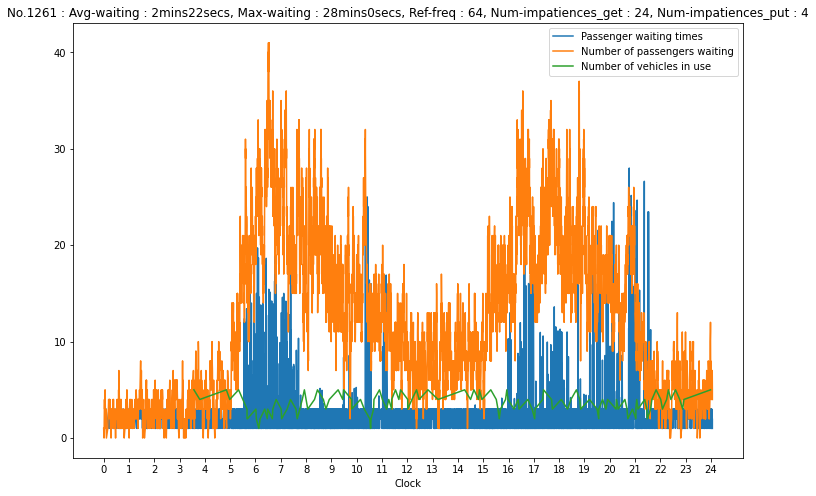

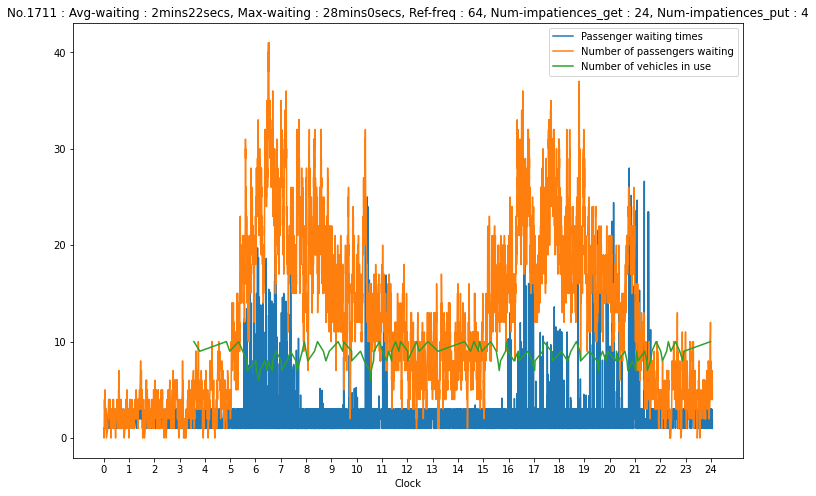

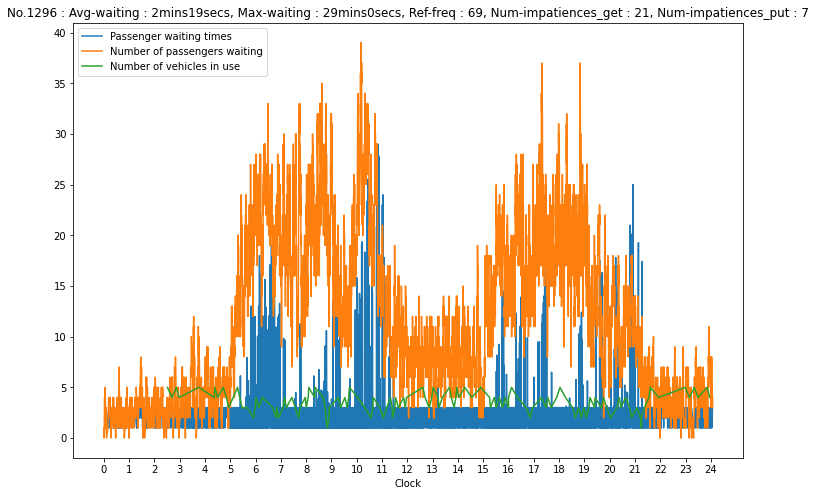

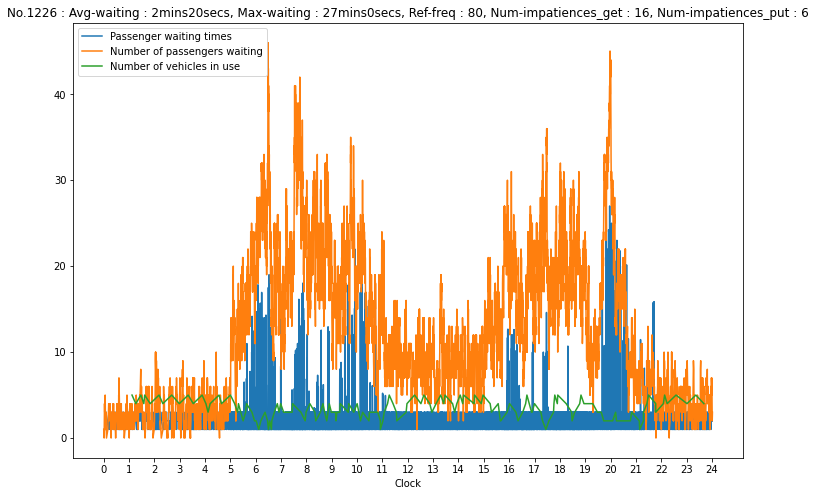

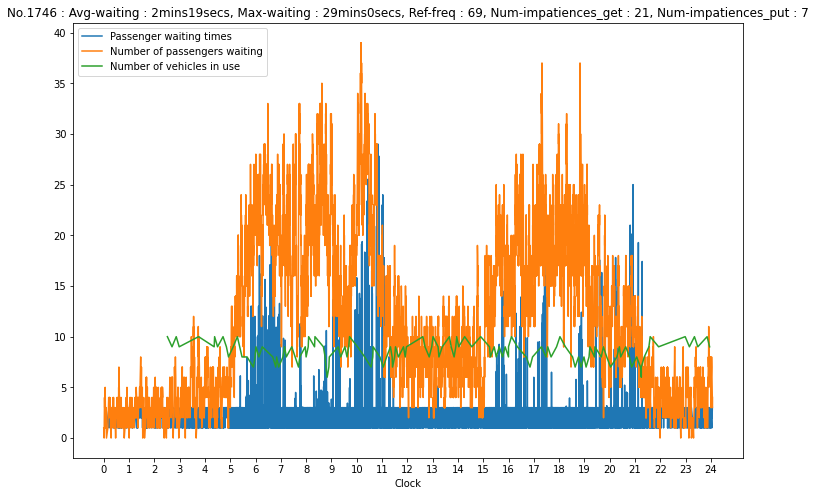

In [23]:
for id, (_) in enumerate(res[:5]):
  plot_func(id, res)

## N.passengers waiting

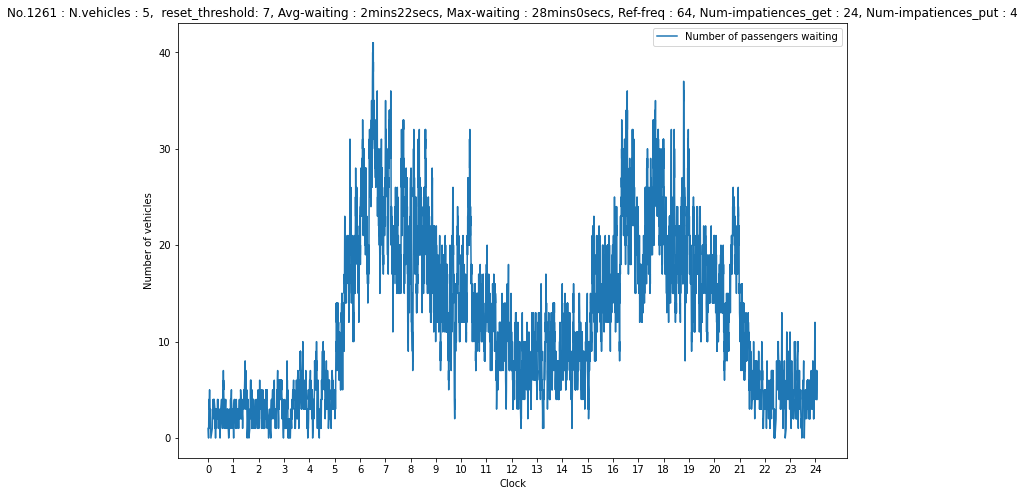

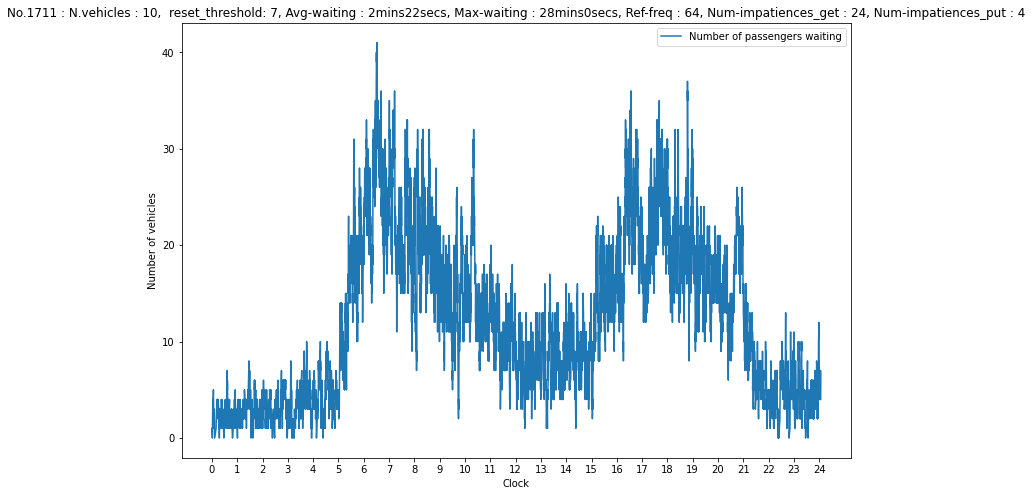

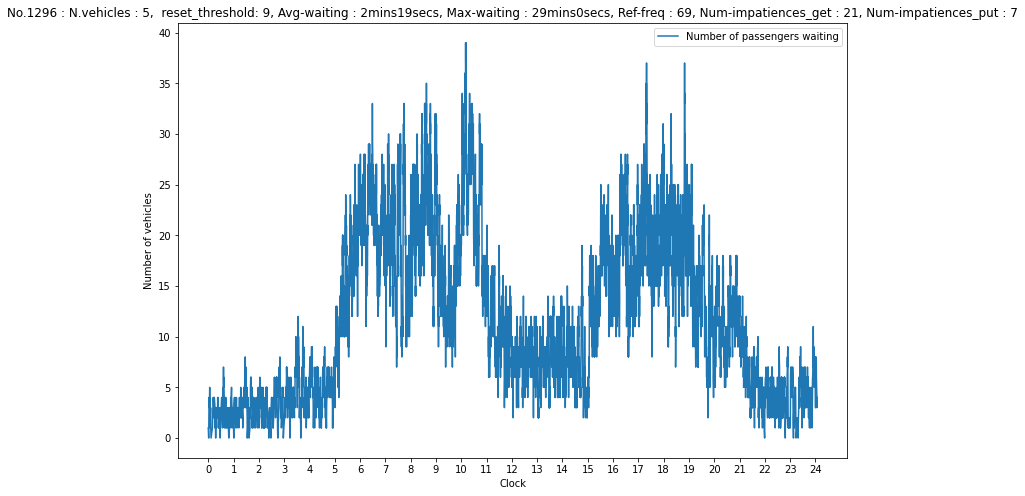

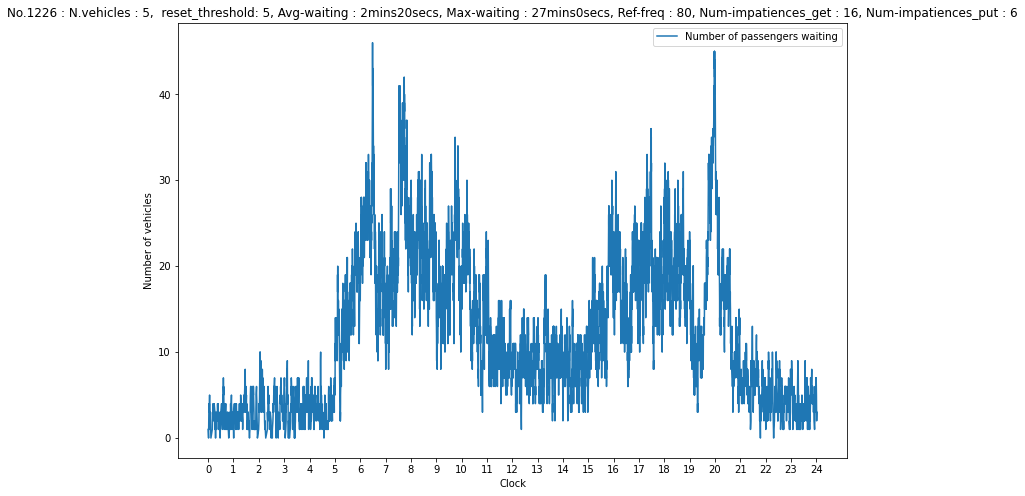

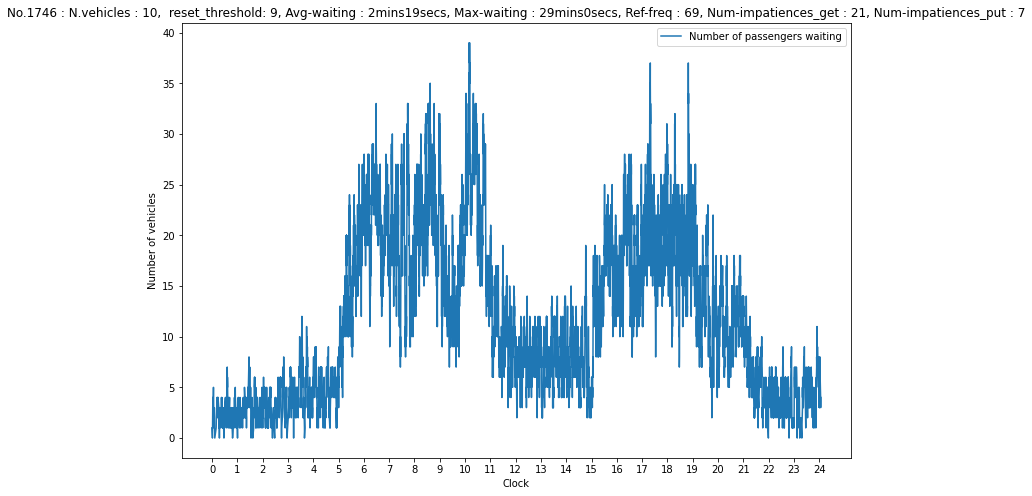

In [24]:
for id in [0,1,2,3,4]:
  x3, y3 = (list(zip(*logs_num_passengers_waiting[res[id][0]])))
  plt.plot(x3, y3, label="Number of passengers waiting")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of vehicles")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

## N.bikes in use

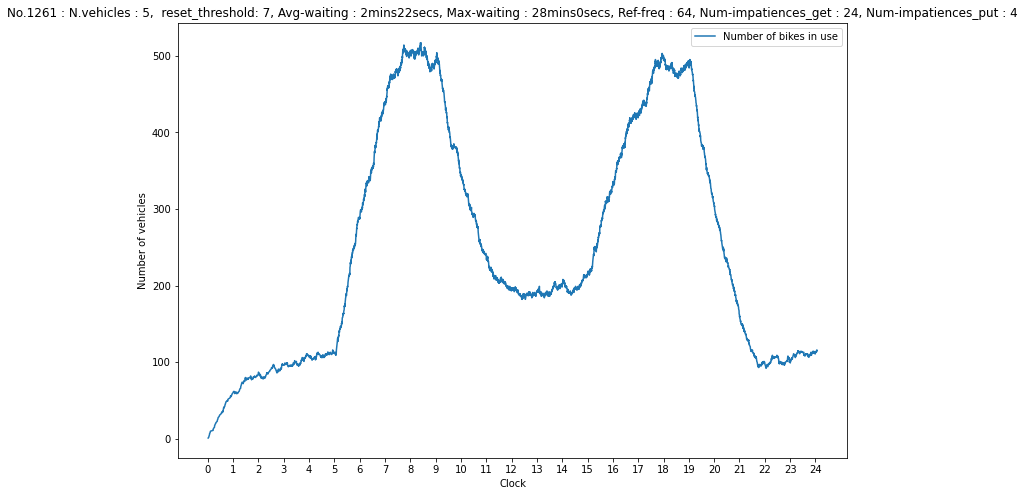

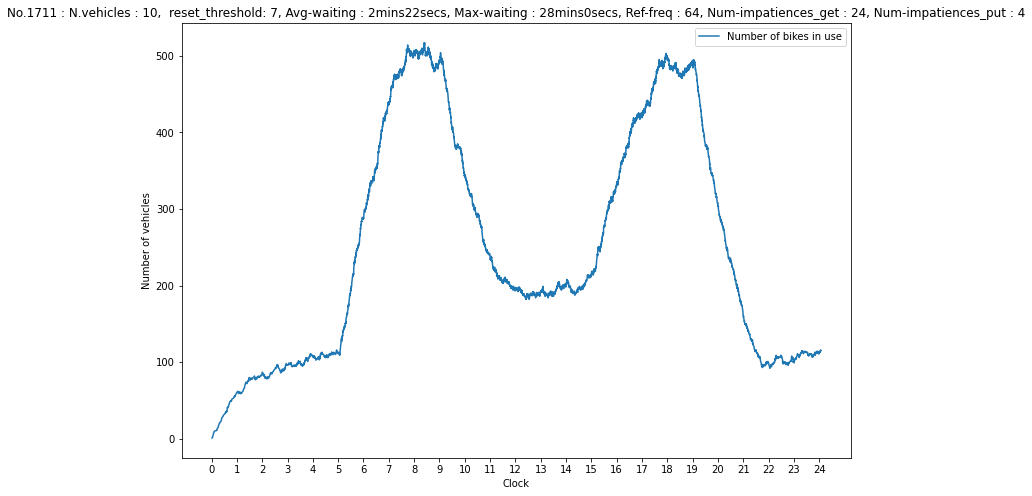

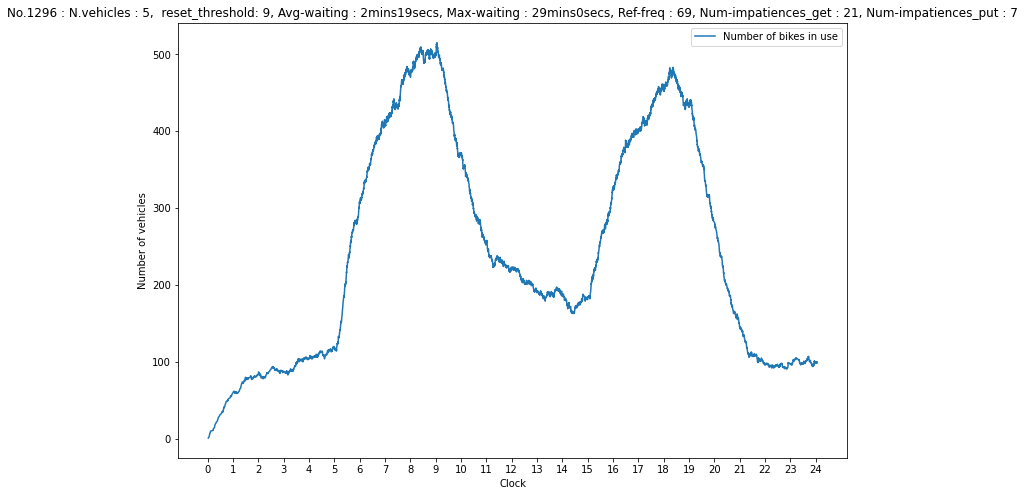

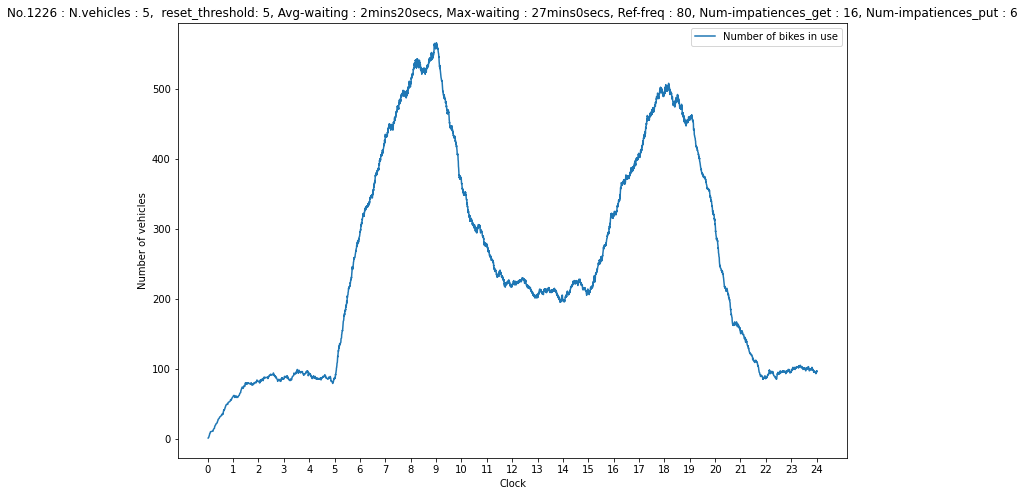

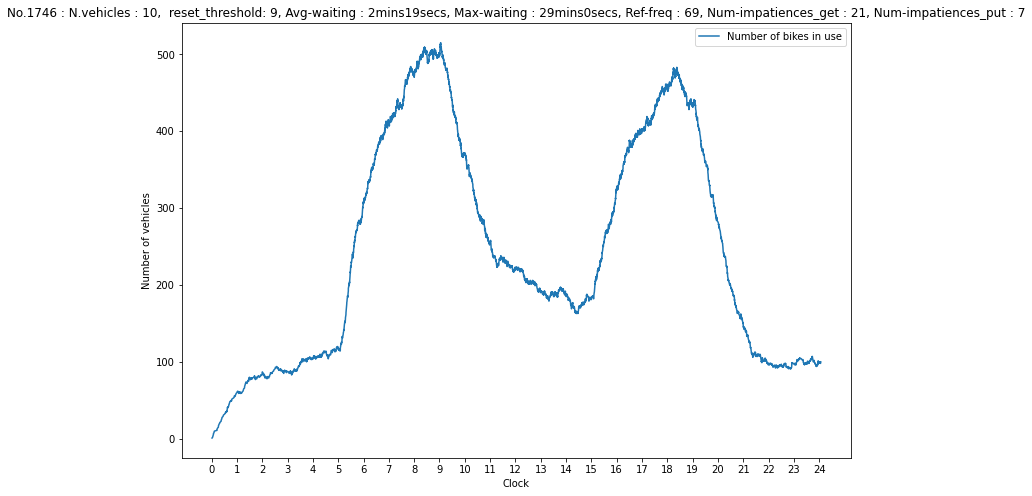

In [25]:
for id in [0,1,2,3,4]:
  x4, y4 = (list(zip(*logs_num_bikes_in_use[res[id][0]])))
  plt.plot(x4, y4, label="Number of bikes in use")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of vehicles")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

## N.passengers

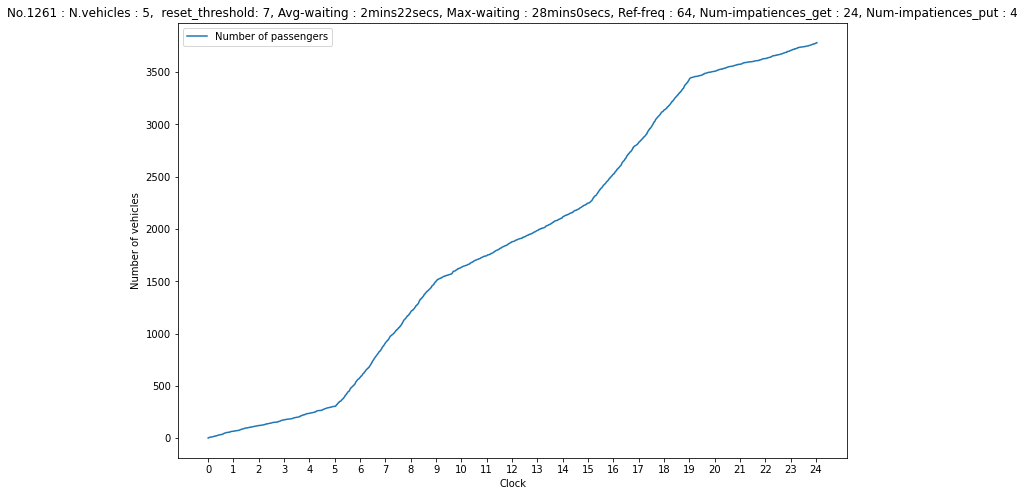

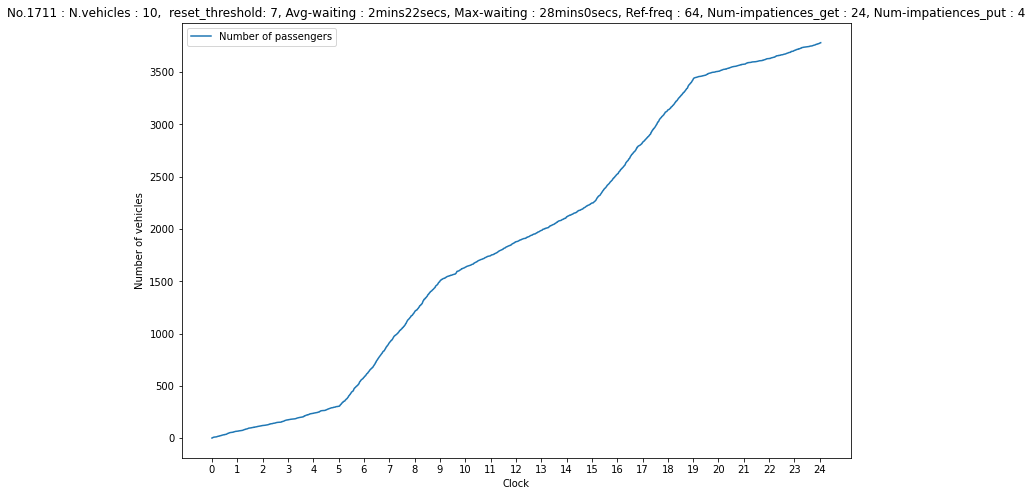

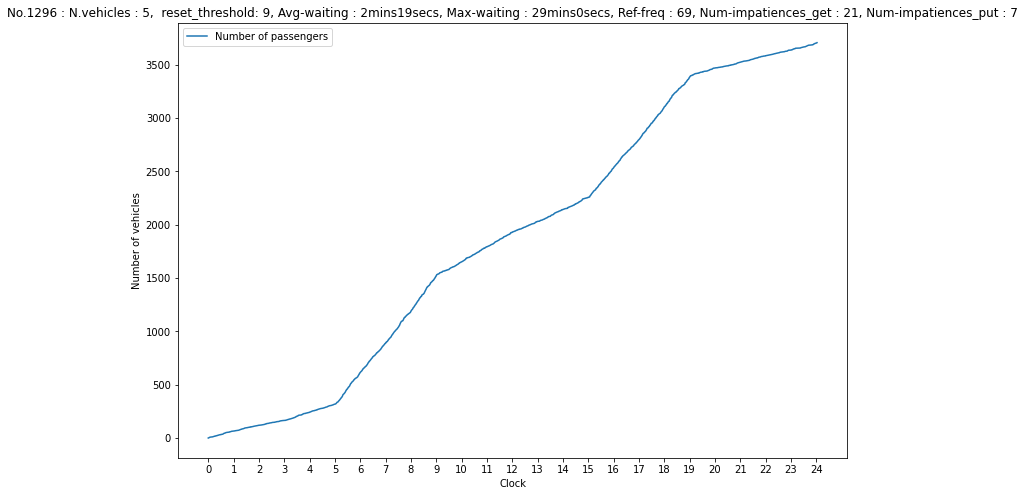

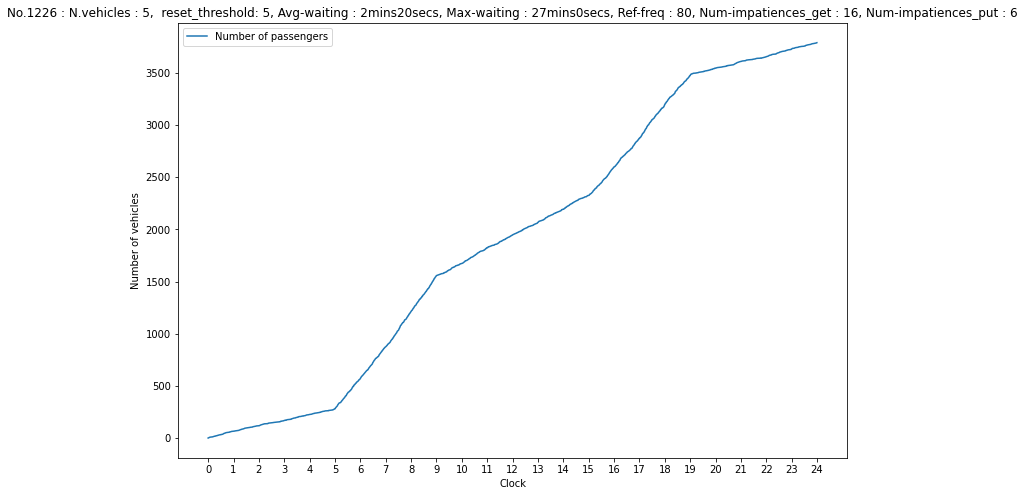

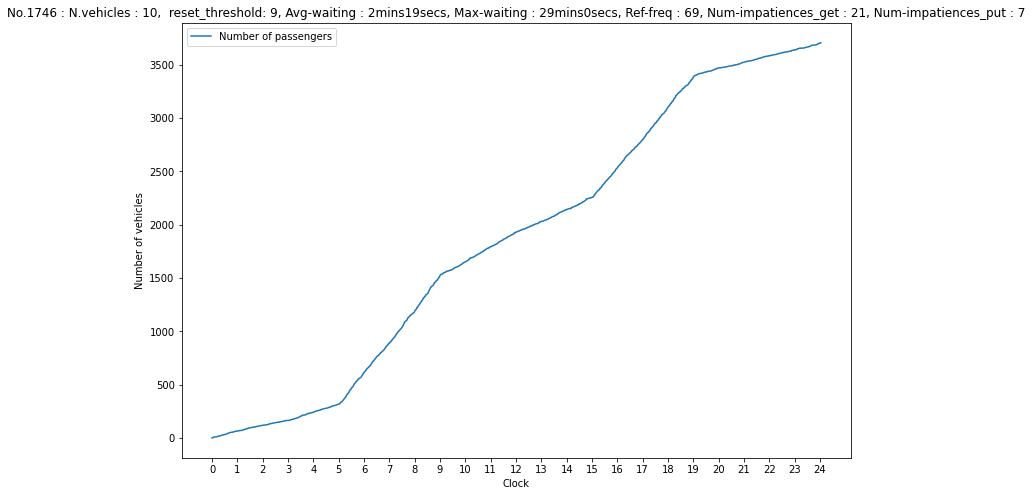

In [26]:
for id in [0,1,2,3,4]:
  x, y = (list(zip(*logs_num_passengers[res[id][0]])))
  plt.plot(x, y, label="Number of passengers")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of vehicles")
  plt.legend(loc='best')
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.show()

## Pasenger waiting times

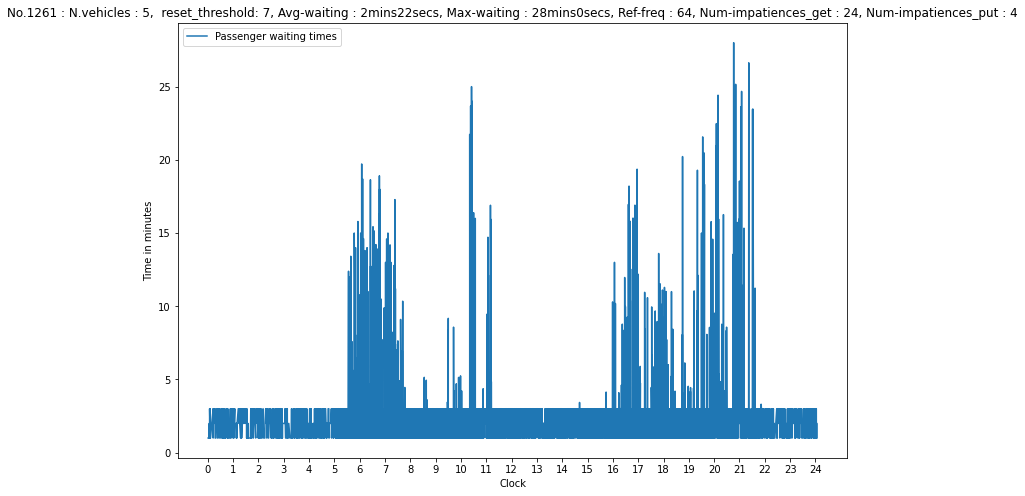

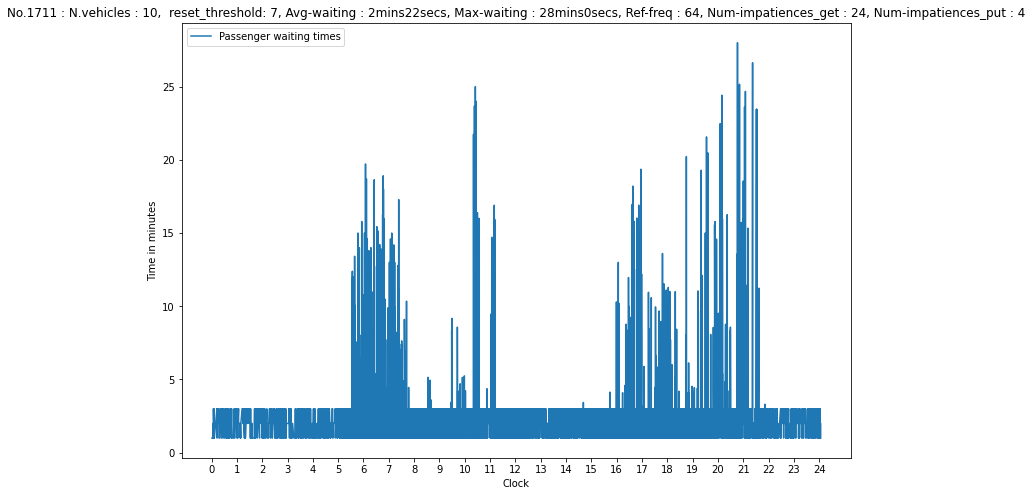

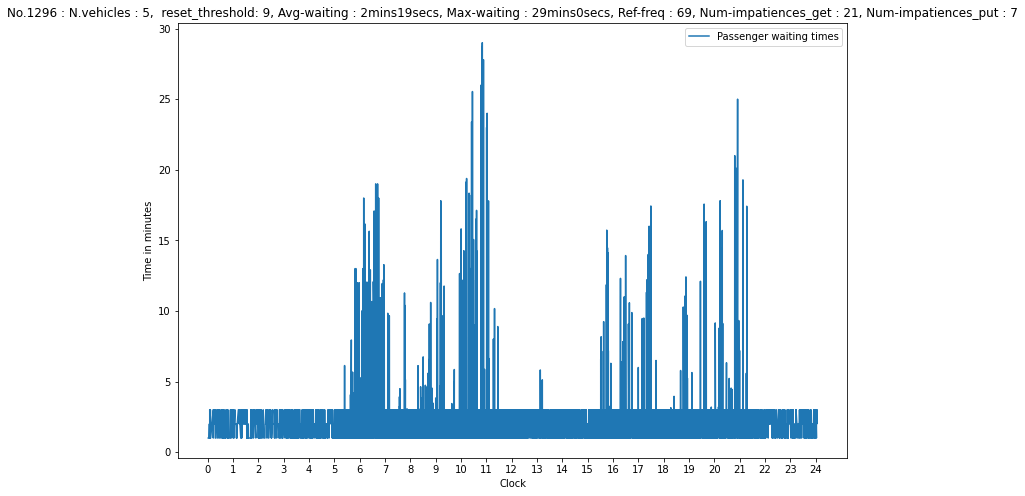

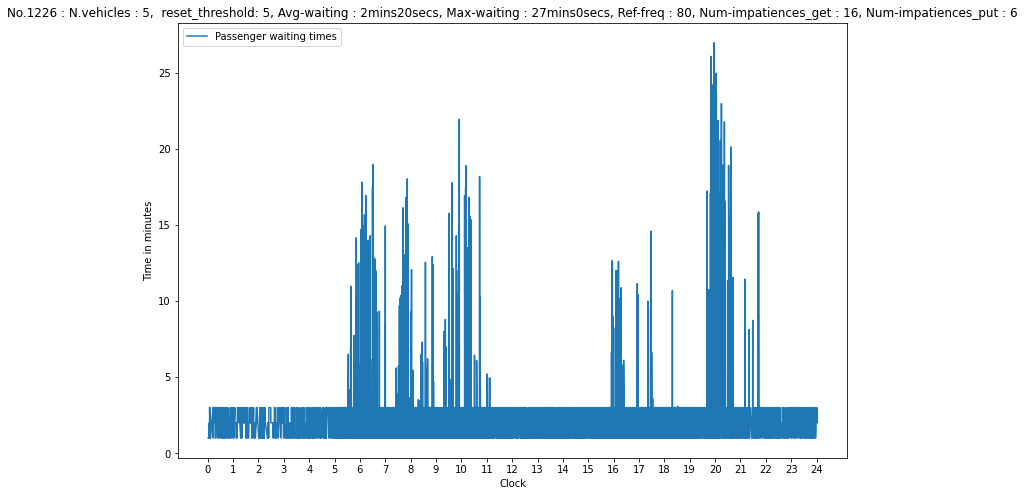

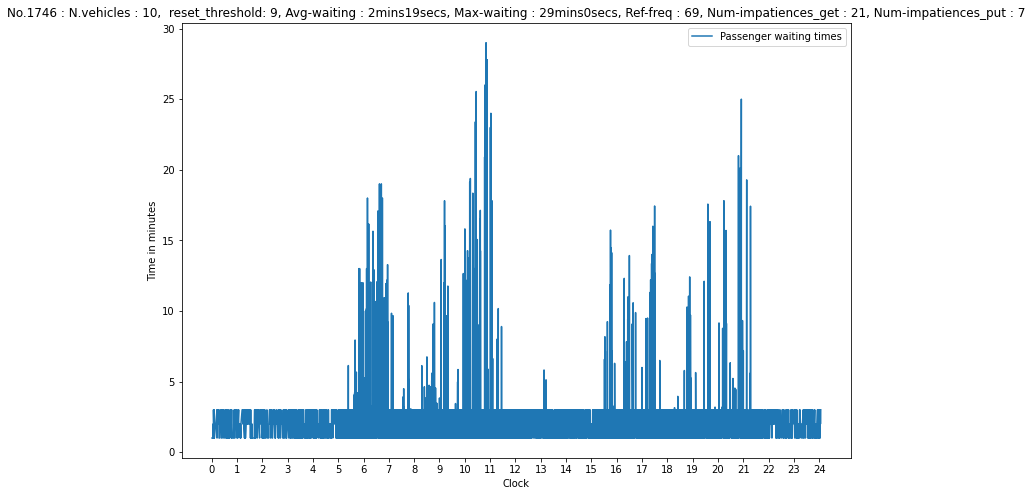

In [27]:
for id in [0,1,2,3,4]:
  x1, y1 = list(zip(*logs_wait_times[res[id][0]]))
  plt.plot(x1, y1, label='Passenger waiting times')
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Time in minutes")
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

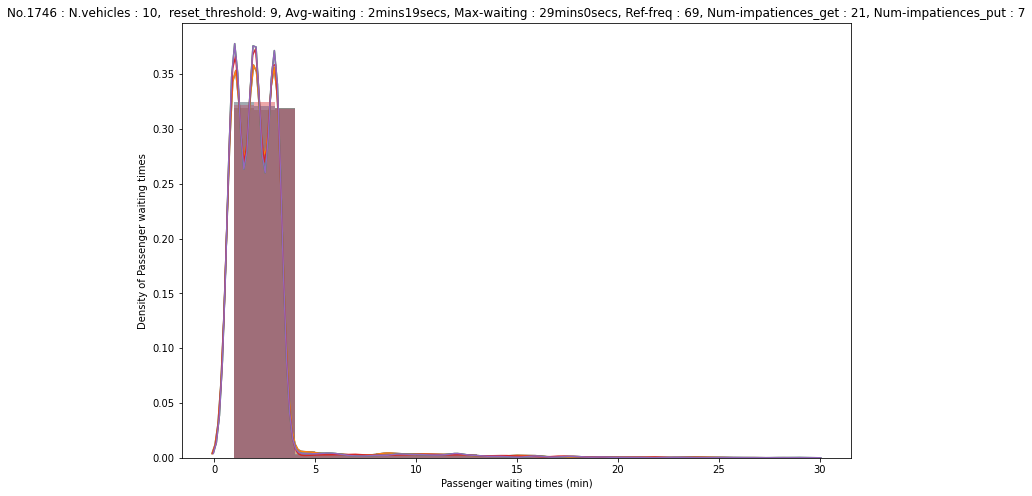

In [28]:
import seaborn as sns

for id in [0,1,2,3,4]:
  # Density Plot
  _, y = list(zip(*logs_wait_times[res[id][0]]))
  sns.distplot(y, bins=np.arange(min(y), max(y), 1), norm_hist=True)
  # plt.xticks(np.arange(min(y), max(y), 10))

  # Plot formatting
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.xlabel('Passenger waiting times (min)')
  plt.ylabel('Density of Passenger waiting times')

## N.vehicles in use

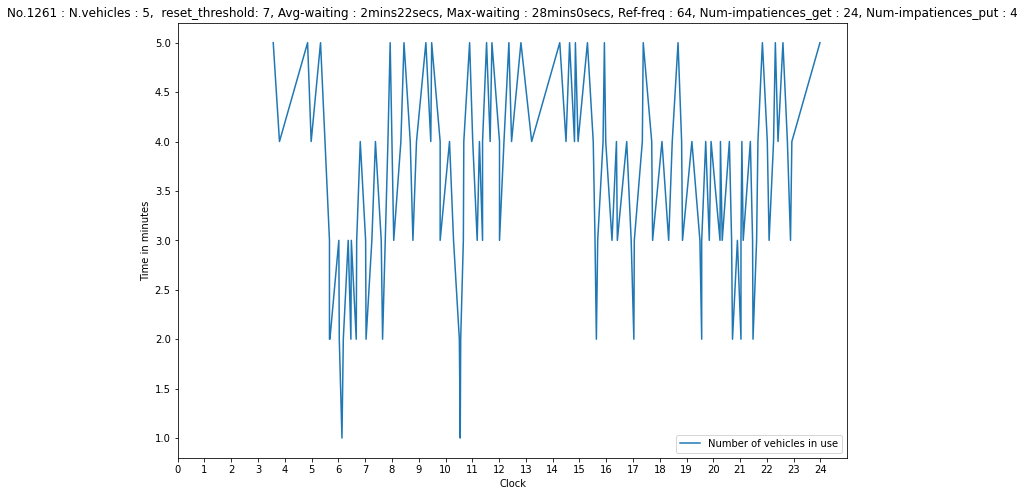

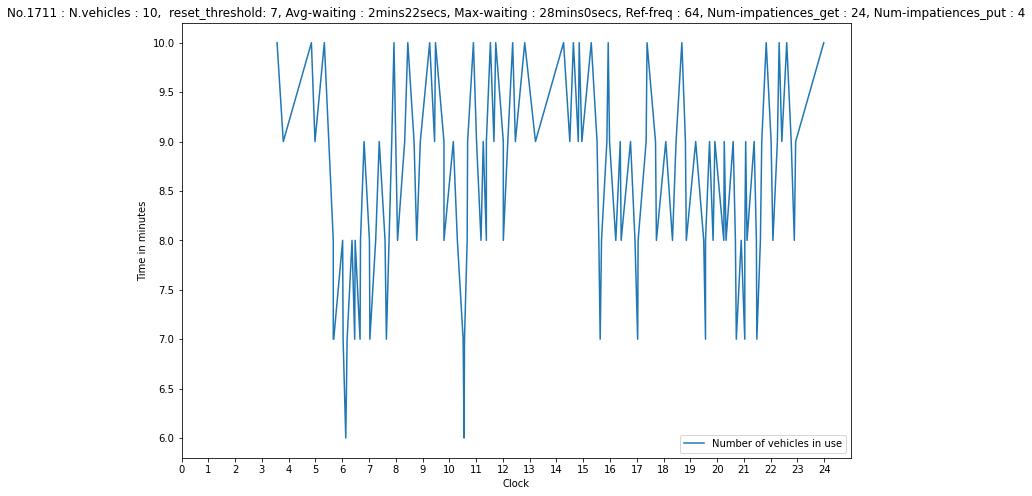

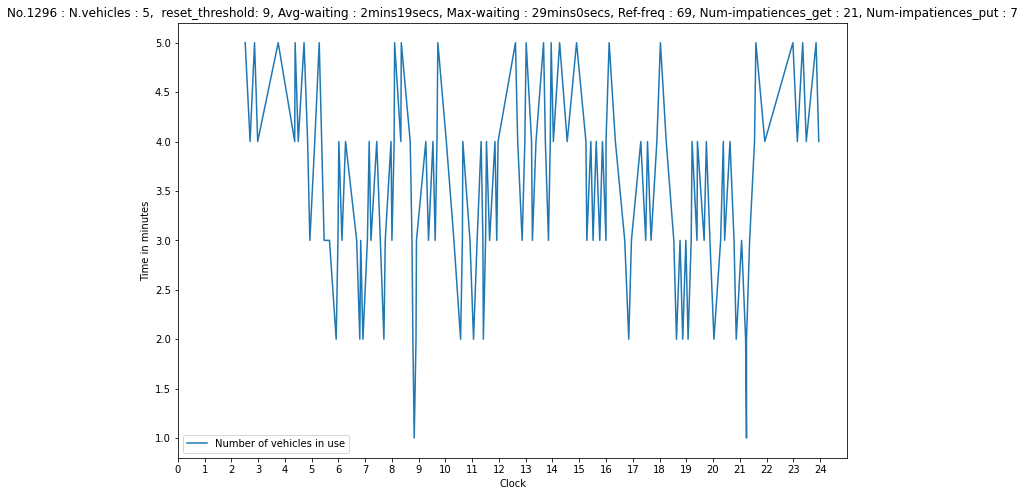

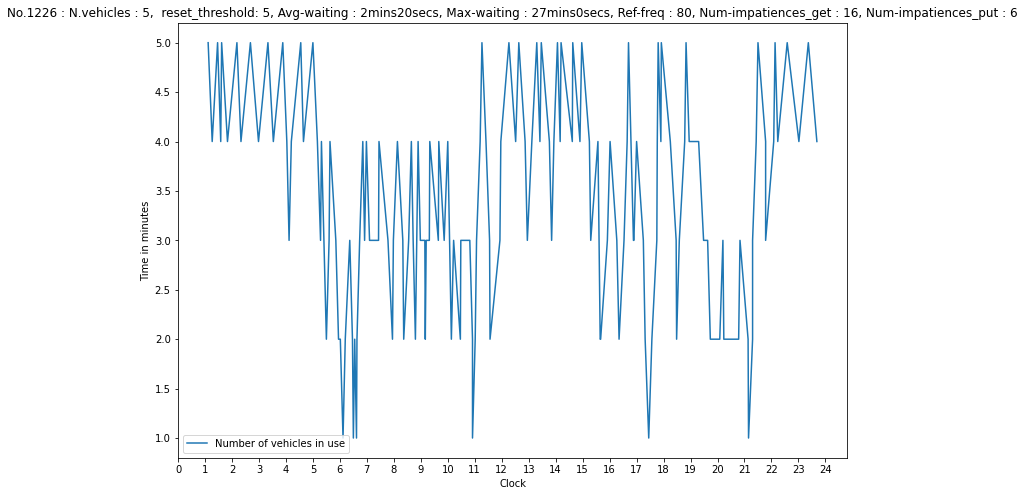

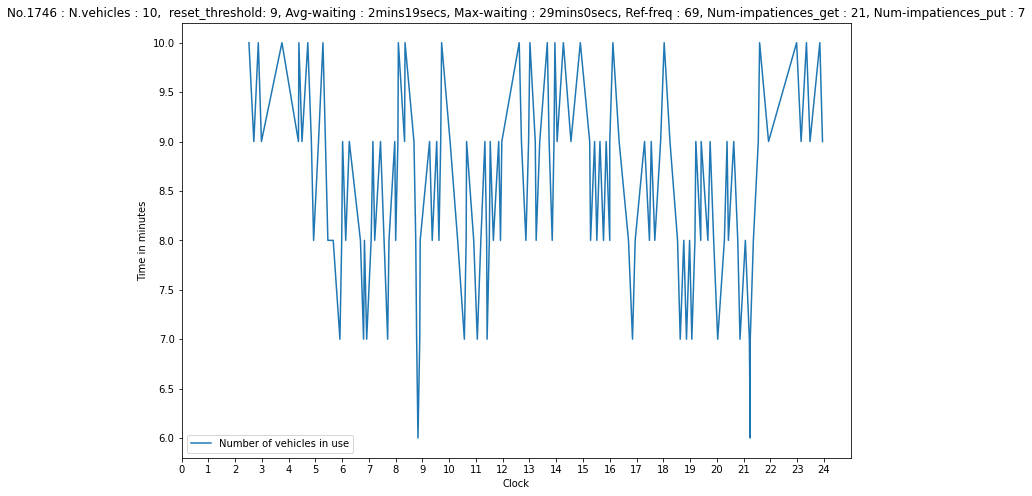

In [29]:
for id in [0,1,2,3,4]:
  x, y = (list(zip(*logs_num_vehicles_in_use[res[id][0]])))
  plt.plot(x, y, label="Number of vehicles in use")
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Time in minutes")
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

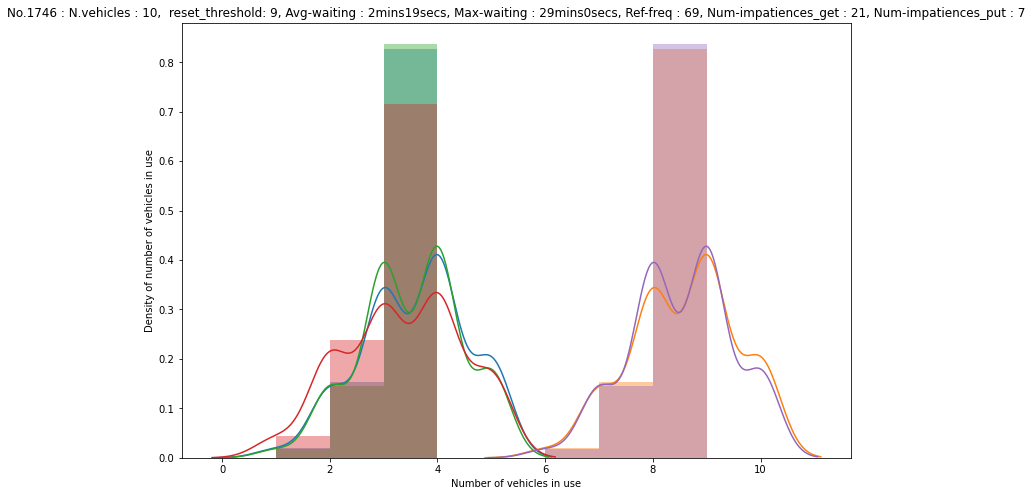

In [30]:
import seaborn as sns

for id in [0,1,2,3,4]:
  # Density Plot
  _, y = (list(zip(*logs_num_vehicles_in_use[res[id][0]])))
  sns.distplot(y, bins=np.arange(min(y), max(y), 1), norm_hist=True)

  # Plot formatting
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.xlabel('Number of vehicles in use')
  plt.ylabel('Density of number of vehicles in use')

## N.impatiences_get, N.impatiences_put

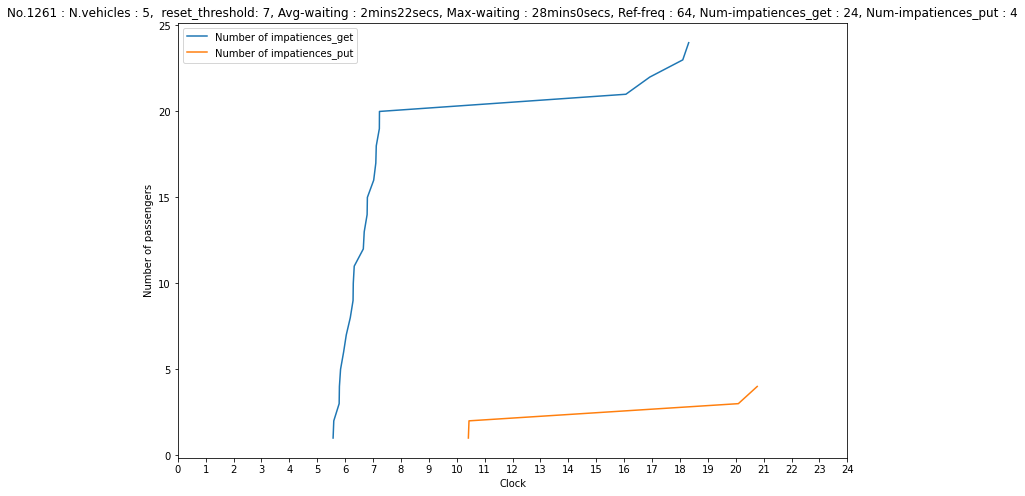

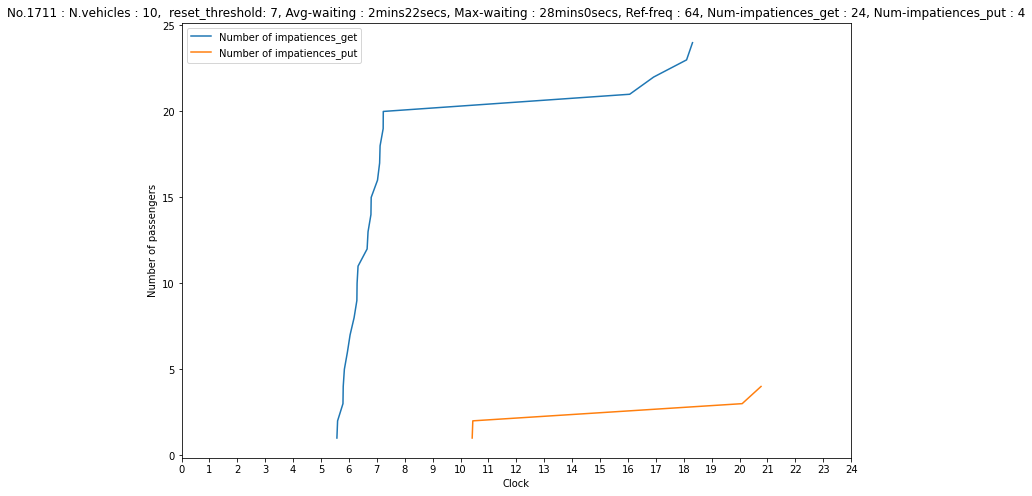

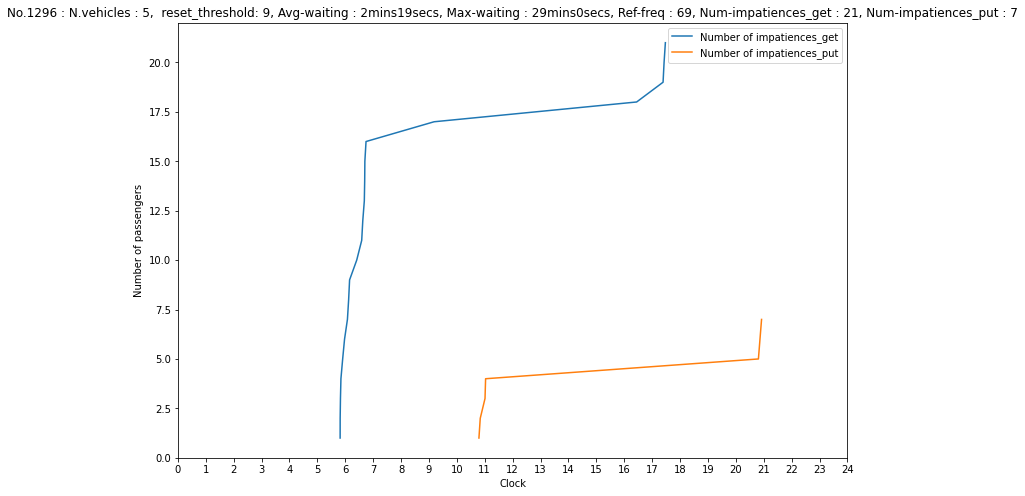

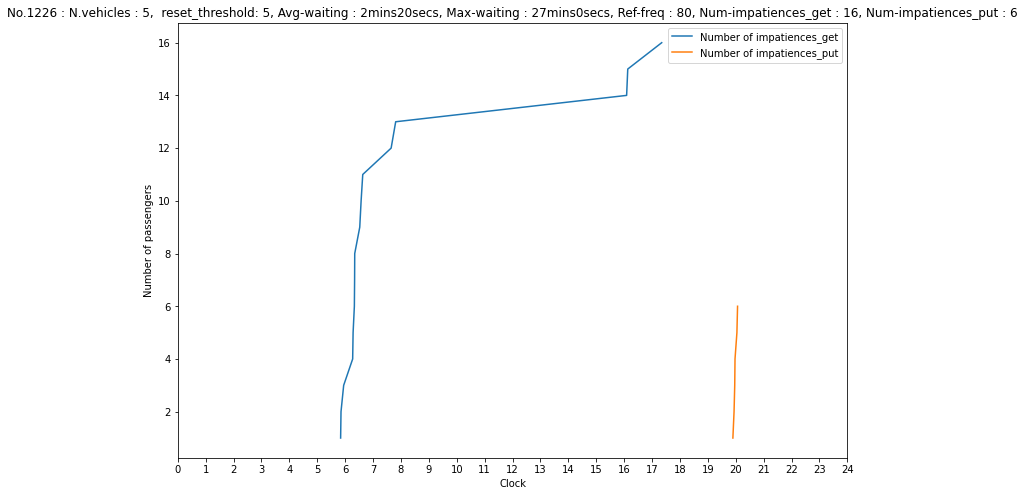

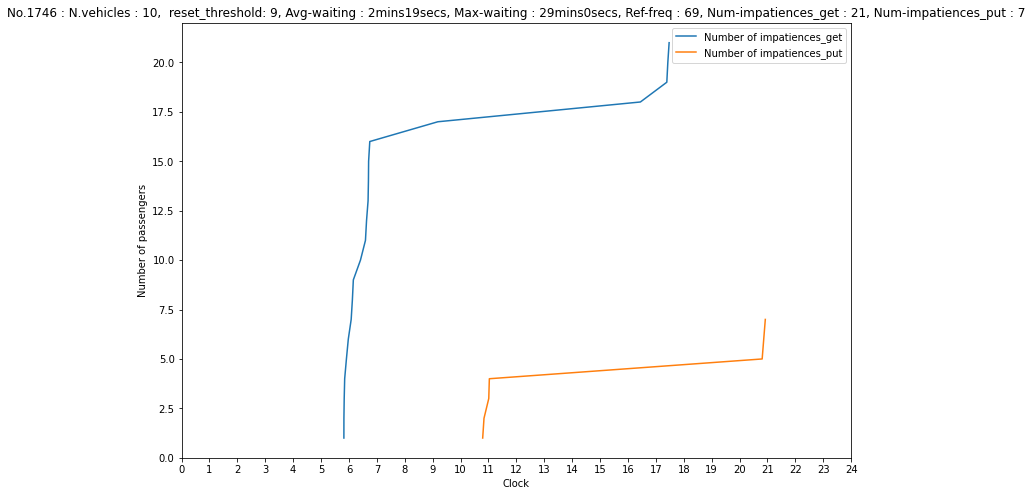

In [31]:
for id in [0,1,2,3,4]:
  if logs_num_impatiences_get[res[id][0]]:
    x1, y1 = list(zip(*logs_num_impatiences_get[res[id][0]]))
    plt.plot(x1, y1, label='Number of impatiences_get')
  if logs_num_impatiences_put[res[id][0]]:
    x2, y2 = list(zip(*logs_num_impatiences_put[res[id][0]]))
    plt.plot(x2, y2, label='Number of impatiences_put')
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of passengers")
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

## Refilling frequency

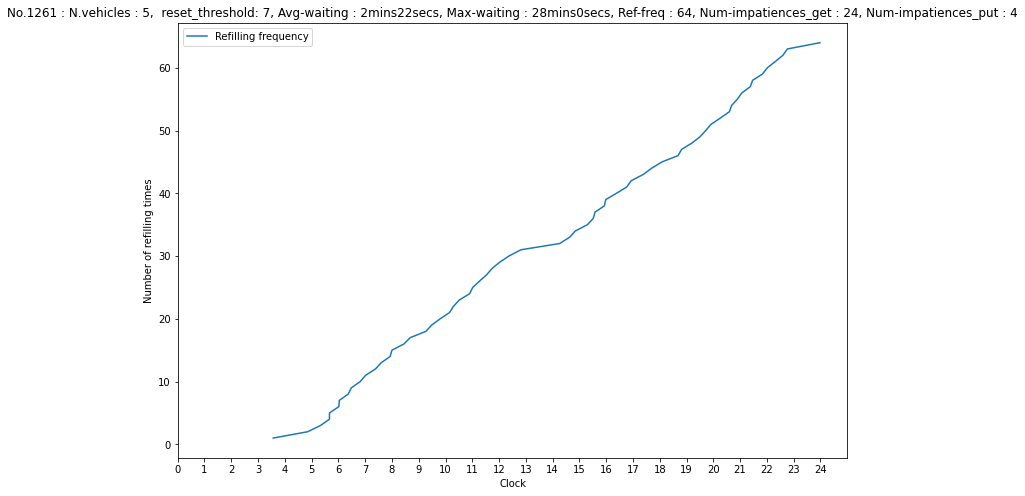

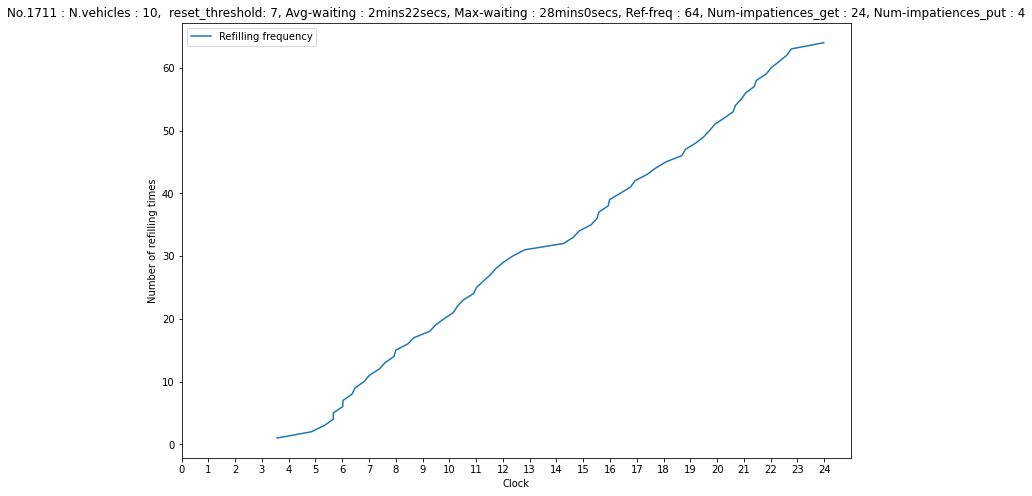

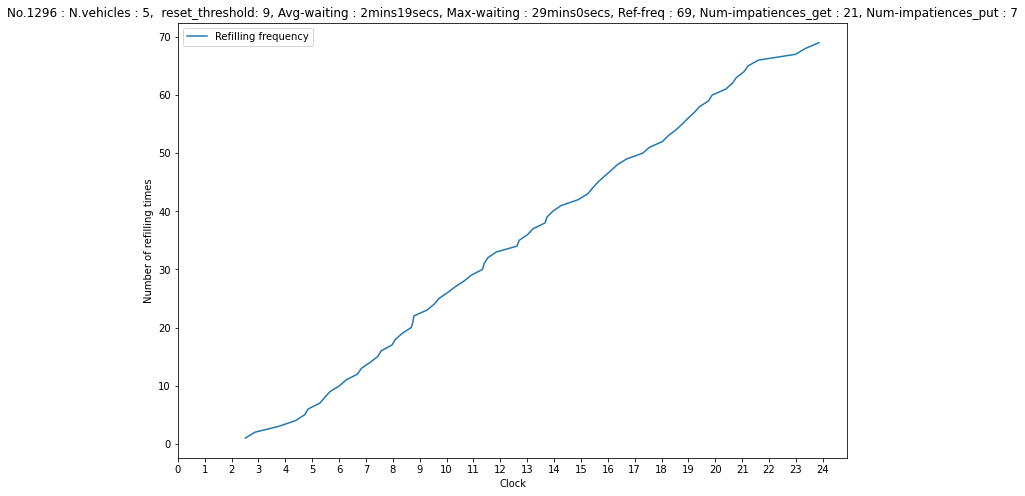

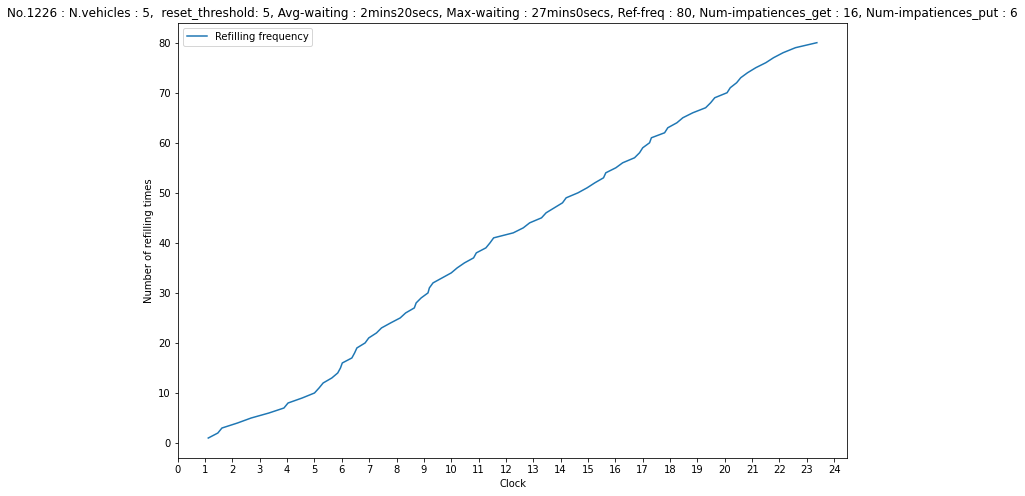

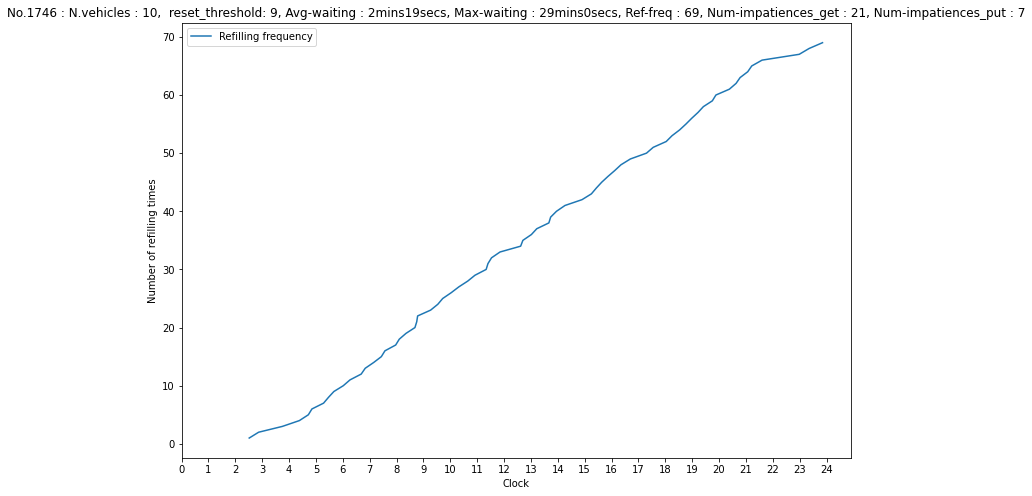

In [32]:
for id in [0,1,2,3,4]:
  x, y = (list(zip(*logs_repo_frequency[res[id][0]])))
  plt.plot(x, y, label='Refilling frequency')
  plt.xticks(np.arange(0, 1441, 60), np.arange(0, 25, 1))
  plt.xlabel("Clock")
  plt.ylabel("Number of refilling times")
  plt.title(f'No.{res[id][0]} : N.vehicles : {res[id][1]},  reset_threshold: {res[id][6]}, Avg-waiting : {res[id][8]}mins{res[id][9]}secs, Max-waiting : {res[id][10]}mins{res[id][11]}secs, Ref-freq : {res[id][12]}, Num-impatiences_get : {res[id][13]}, Num-impatiences_put : {res[id][14]}')
  plt.legend(loc='best')
  plt.show()

# Case study :

## 1. Switch off **Refilling strategy**.

In [33]:
REFILL_FLAG = False
SHOW_RESULT_FLAG = True

# Logs
log_wait_times = []
log_repo_frequency = []
log_num_passengers = []
log_num_passengers_waiting = []
log_num_bikes_in_use = []
log_num_vehicles_in_use = []
log_num_impatiences_get = []
log_num_impatiences_put = []

# Marco variables
id = 0
repo_frequency = 0
num_impatiences_get = 0
num_impatiences_put = 0
num_passengers_waiting = 0
num_bike_in_use = 0
num_vehicles_in_use = 0
""" num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
main(id, 5, 20, 20, 0.7, 0.1, 7, 10)

-------------------------------------------------------------------
Running simulation 0 times ... 
Num_vehicles: 5, Num_stations : 20, Capacity : 20, Init_ratio : 0.7, Reset_ratio : 0.1, Reset_threshold : 7, Reset_delay : 10
Finished at time :1442.4280813998757 
The average wait time is 5 minutes and 22 seconds. 
The max wait time is 21 minutes and 53 seconds. 
Refilling frequency : 0. 
Num_impatiences_get : 1027. 
Num_impatiences_put : 0. 
Num_passengers : 3709.


(5, 22, 21, 53, 0, 1027, 0)

## 2. Switch off **Patience strategy** and Switch off **Refilling strategy** .

In [34]:
REFILL_FLAG = False
PATIENCE_FLAG = False
SHOW_RESULT_FLAG = True

# Logs
log_wait_times = []
log_repo_frequency = []
log_num_passengers = []
log_num_passengers_waiting = []
log_num_bikes_in_use = []
log_num_vehicles_in_use = []
log_num_impatiences_get = []
log_num_impatiences_put = []

# Marco variables
id = 0
repo_frequency = 0
num_impatiences_get = 0
num_impatiences_put = 0
num_passengers_waiting = 0
num_bike_in_use = 0
num_vehicles_in_use = 0
""" num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
main(id, 5, 20, 20, 0.7, 0.1, 7, 10)

-------------------------------------------------------------------
Running simulation 0 times ... 
Num_vehicles: 5, Num_stations : 20, Capacity : 20, Init_ratio : 0.7, Reset_ratio : 0.1, Reset_threshold : 7, Reset_delay : 10
Finished at time :1442.0817389632332 
The average wait time is 63 minutes and 30 seconds. 
The max wait time is 435 minutes and 30 seconds. 
Refilling frequency : 0. 
Num_impatiences_get : 0. 
Num_impatiences_put : 0. 
Num_passengers : 3755.


(63, 30, 435, 30, 0, 0, 0)

## 3. Grid search for **Num_vehieles**.

In [35]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res1 = []
logs1_wait_times = []
logs1_repo_frequency = []
logs1_num_passengers = []
logs1_num_passengers_waiting = []
logs1_num_bikes_in_use = []
logs1_num_vehicles_in_use = []
logs1_num_impatiences_get = []
logs1_num_impatiences_put = []

num_stations=20
capacity=20
init_ratio=0.7
reset_ratio=0.1
reset_threshold=7
reset_delay=10

for id, num_vehicles in enumerate([1,2,5,10,15,20]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers_waiting = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """                  
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res1.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs1_wait_times.append(log_wait_times)
  logs1_repo_frequency.append(log_repo_frequency)
  logs1_num_passengers.append(log_num_passengers)
  logs1_num_passengers_waiting.append(log_num_passengers_waiting)
  logs1_num_bikes_in_use.append(log_num_bikes_in_use)
  logs1_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs1_num_impatiences_get.append(log_num_impatiences_get)
  logs1_num_impatiences_put.append(log_num_impatiences_put)

In [36]:
show_table(res1)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,1,20,0.7,0.1,7,10,4 mins 20 secs,29 mins 0 secs,18,618,41
1,2,20,0.7,0.1,7,10,3 mins 3 secs,29 mins 0 secs,42,197,47
2,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
3,10,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
4,15,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
5,20,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4


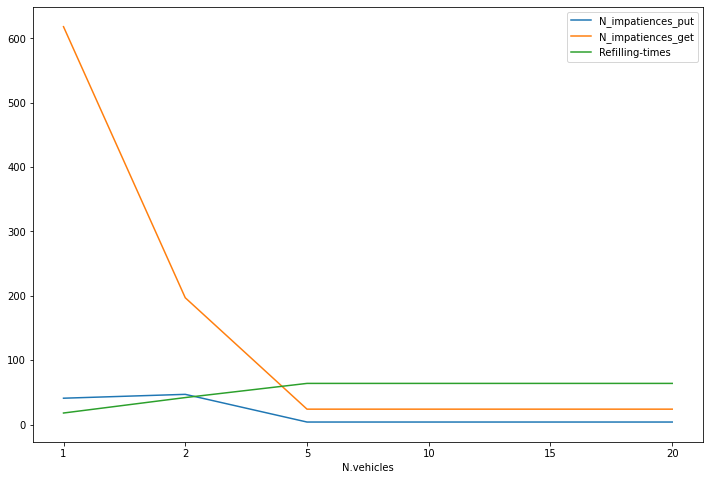

In [37]:
plt.plot(range(0,len(res1)), [row[-1] for row in res1], label='N_impatiences_put')
plt.plot(range(0,len(res1)), [row[-2] for row in res1], label='N_impatiences_get')
plt.plot(range(0,len(res1)), [row[-3] for row in res1], label='Refilling-times')
plt.xticks(range(0,len(res1)), [1,2,5,10,15,20])
plt.xlabel("N.vehicles")
plt.legend(loc='best')
plt.show()

## 4. Grid search for **capacity**.

In [38]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res2 = []
logs2_wait_times = []
logs2_repo_frequency = []
logs2_num_passengers = []
logs2_num_passengers_waiting = []
logs2_num_bikes_in_use = []
logs2_num_vehicles_in_use = []
logs2_num_impatiences_get = []
logs2_num_impatiences_put = []

num_vehicles=5
num_stations=20
init_ratio=0.7
reset_ratio=0.1
reset_threshold=7
reset_delay=10

for id, capacity in enumerate([5,10,15,20,25,30]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers_waiting = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """ 
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res2.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs2_wait_times.append(log_wait_times)
  logs2_repo_frequency.append(log_repo_frequency)
  logs2_num_passengers.append(log_num_passengers)
  logs2_num_passengers_waiting.append(log_num_passengers_waiting)
  logs2_num_bikes_in_use.append(log_num_bikes_in_use)
  logs2_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs2_num_impatiences_get.append(log_num_impatiences_get)
  logs2_num_impatiences_put.append(log_num_impatiences_put)

In [39]:
show_table(res2)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,5,0.7,0.1,7,10,6 mins 7 secs,29 mins 53 secs,100,899,120
1,5,10,0.7,0.1,7,10,3 mins 50 secs,29 mins 59 secs,87,219,66
2,5,15,0.7,0.1,7,10,3 mins 3 secs,29 mins 56 secs,82,116,40
3,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
4,5,25,0.7,0.1,7,10,2 mins 13 secs,27 mins 0 secs,55,19,5
5,5,30,0.7,0.1,7,10,2 mins 10 secs,23 mins 0 secs,49,19,1


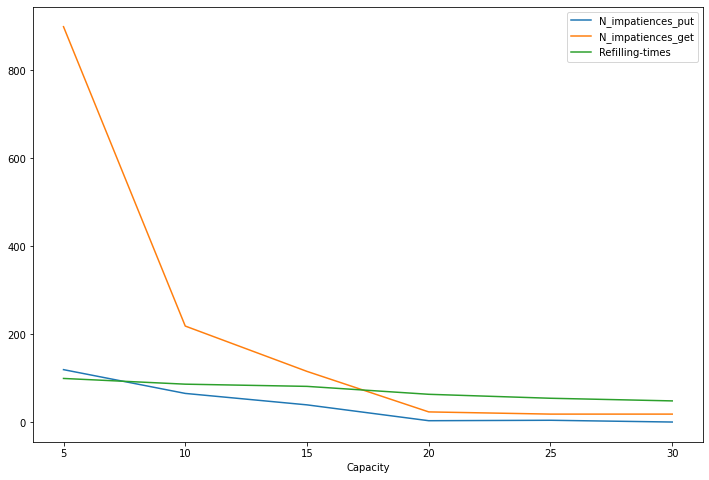

In [40]:
plt.plot(range(0,len(res2)), [row[-1] for row in res2], label='N_impatiences_put')
plt.plot(range(0,len(res2)), [row[-2] for row in res2], label='N_impatiences_get')
plt.plot(range(0,len(res2)), [row[-3] for row in res2], label='Refilling-times')
plt.xticks(range(0,len(res2)), [5,10,15,20,25,30])
plt.xlabel("Capacity")
plt.legend(loc='best')
plt.show()

## 5. Grid search for **init_ratio**.

In [41]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res3 = []
logs3_wait_times = []
logs3_repo_frequency = []
logs3_num_passengers = []
logs3_num_passengers_waiting = []
logs3_num_bikes_in_use = []
logs3_num_vehicles_in_use = []
logs3_num_impatiences_get = []
logs3_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=20
reset_ratio=0.1
reset_threshold=7
reset_delay=10

for id, init_ratio in enumerate([0.5,0.6,0.7,0.8,0.9]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers_waiting = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res3.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs3_wait_times.append(log_wait_times)
  logs3_repo_frequency.append(log_repo_frequency)
  logs3_num_passengers.append(log_num_passengers)
  logs3_num_passengers_waiting.append(log_num_passengers_waiting)
  logs3_num_bikes_in_use.append(log_num_bikes_in_use)
  logs3_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs3_num_impatiences_get.append(log_num_impatiences_get)
  logs3_num_impatiences_put.append(log_num_impatiences_put)

In [42]:
show_table(res3)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,20,0.5,0.1,7,10,2 mins 41 secs,29 mins 0 secs,69,71,17
1,5,20,0.6,0.1,7,10,2 mins 27 secs,29 mins 0 secs,69,30,15
2,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
3,5,20,0.8,0.1,7,10,2 mins 31 secs,30 mins 23 secs,62,45,22
4,5,20,0.9,0.1,7,10,2 mins 29 secs,28 mins 0 secs,69,48,12


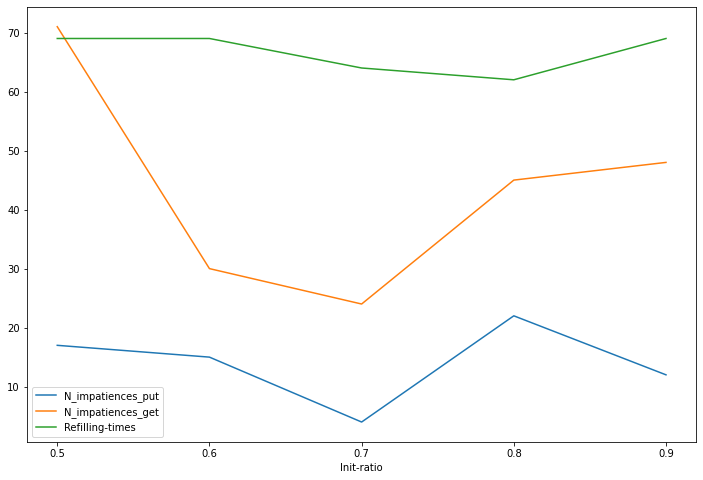

In [43]:
plt.plot(range(0,len(res3)), [row[-1] for row in res3], label='N_impatiences_put')
plt.plot(range(0,len(res3)), [row[-2] for row in res3], label='N_impatiences_get')
plt.plot(range(0,len(res3)), [row[-3] for row in res3], label='Refilling-times')
plt.xticks(range(0,len(res3)), [0.5,0.6,0.7,0.8,0.9])
plt.xlabel("Init-ratio")
plt.legend(loc='best')
plt.show()

## 6. Grid search for **reset_ratio**.

In [44]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res4 = []
logs4_wait_times = []
logs4_repo_frequency = []
logs4_num_passengers = []
logs4_num_passengers_waiting = []
logs4_num_bikes_in_use = []
logs4_num_vehicles_in_use = []
logs4_num_impatiences_get = []
logs4_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=20
init_ratio=0.7
reset_threshold=7
reset_delay=10

for id, reset_ratio in enumerate([0.1,0.2,0.3,0.4]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers_waiting = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res4.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs4_wait_times.append(log_wait_times)
  logs4_repo_frequency.append(log_repo_frequency)
  logs4_num_passengers.append(log_num_passengers)
  logs4_num_passengers_waiting.append(log_num_passengers_waiting)
  logs4_num_bikes_in_use.append(log_num_bikes_in_use)
  logs4_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs4_num_impatiences_get.append(log_num_impatiences_get)
  logs4_num_impatiences_put.append(log_num_impatiences_put)

In [45]:
show_table(res4)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
1,5,20,0.7,0.2,7,10,2 mins 25 secs,29 mins 0 secs,81,24,14
2,5,20,0.7,0.3,7,10,2 mins 10 secs,27 mins 26 secs,94,10,2
3,5,20,0.7,0.4,7,10,2 mins 17 secs,30 mins 15 secs,105,18,24


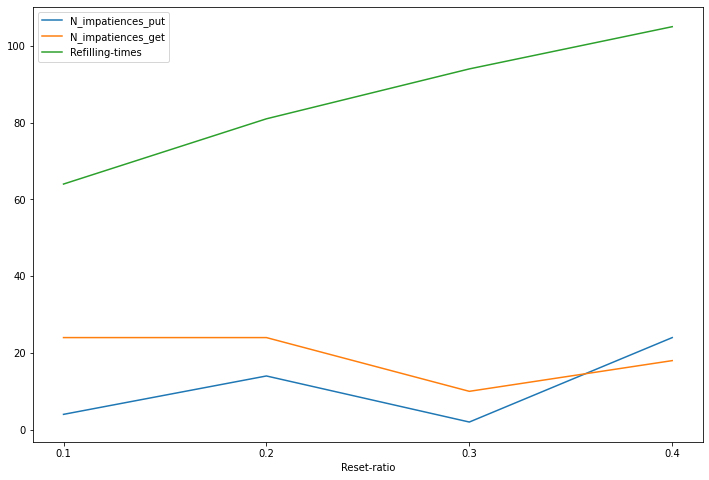

In [46]:
plt.plot(range(0,len(res4)), [row[-1] for row in res4], label='N_impatiences_put')
plt.plot(range(0,len(res4)), [row[-2] for row in res4], label='N_impatiences_get')
plt.plot(range(0,len(res4)), [row[-3] for row in res4], label='Refilling-times')
plt.xticks(range(0,len(res4)), [0.1,0.2,0.3,0.4])
plt.xlabel("Reset-ratio")
plt.legend(loc='best')
plt.show()

## 7. Grid search for **reset_threshold**.

In [47]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res5 = []
logs5_wait_times = []
logs5_repo_frequency = []
logs5_num_passengers = []
logs5_num_passengers_waiting = []
logs5_num_bikes_in_use = []
logs5_num_vehicles_in_use = []
logs5_num_impatiences_get = []
logs5_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=20
init_ratio=0.7
reset_ratio=0.1
reset_delay=10

for id, reset_threshold in enumerate([5,6,7,8,9]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers_waiting = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res5.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs5_wait_times.append(log_wait_times)
  logs5_repo_frequency.append(log_repo_frequency)
  logs5_num_passengers.append(log_num_passengers)
  logs5_num_passengers_waiting.append(log_num_passengers_waiting)
  logs5_num_bikes_in_use.append(log_num_bikes_in_use)
  logs5_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs5_num_impatiences_get.append(log_num_impatiences_get)
  logs5_num_impatiences_put.append(log_num_impatiences_put)

In [48]:
show_table(res5)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,20,0.7,0.1,5,10,2 mins 22 secs,29 mins 20 secs,72,32,14
1,5,20,0.7,0.1,6,10,2 mins 25 secs,29 mins 0 secs,60,36,14
2,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
3,5,20,0.7,0.1,8,10,2 mins 27 secs,27 mins 14 secs,62,46,3
4,5,20,0.7,0.1,9,10,2 mins 28 secs,29 mins 0 secs,67,27,24


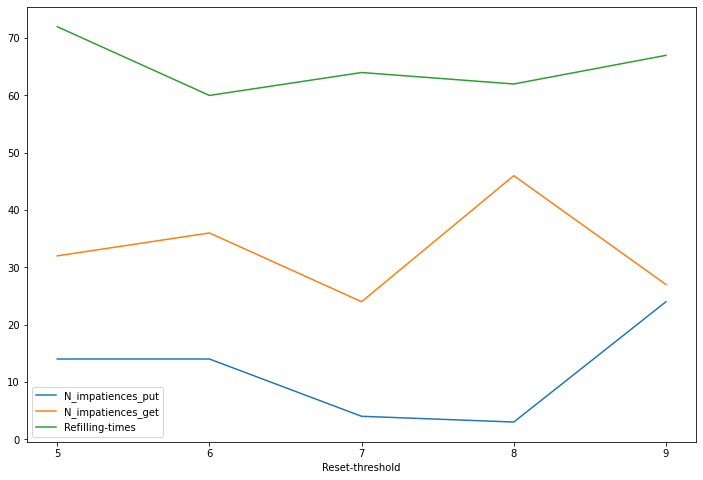

In [49]:
plt.plot(range(0,len(res5)), [row[-1] for row in res5], label='N_impatiences_put')
plt.plot(range(0,len(res5)), [row[-2] for row in res5], label='N_impatiences_get')
plt.plot(range(0,len(res5)), [row[-3] for row in res5], label='Refilling-times')
plt.xticks(range(0,len(res5)), [5,6,7,8,9])
plt.xlabel("Reset-threshold")
plt.legend(loc='best')
plt.show()

## 8. Grid search for **reset_delay**.

In [50]:
REFILL_FLAG = True
PATIENCE_FLAG = True
SHOW_RESULT_FLAG = False

res6 = []
logs6_wait_times = []
logs6_repo_frequency = []
logs6_num_passengers = []
logs6_num_passengers_waiting = []
logs6_num_bikes_in_use = []
logs6_num_vehicles_in_use = []
logs6_num_impatiences_get = []
logs6_num_impatiences_put = []

num_vehicles=5
num_stations=20
capacity=20
init_ratio=0.7
reset_ratio=0.1
reset_threshold=7

for id, reset_delay in enumerate([1,2,5,10,20,30,40,50,60]):
  # Logs
  log_wait_times = []
  log_repo_frequency = []
  log_num_passengers = []
  log_num_passengers_waiting = []
  log_num_bikes_in_use = []
  log_num_vehicles_in_use = []
  log_num_impatiences_get = []
  log_num_impatiences_put = []

  # Marco variables
  repo_frequency = 0
  num_impatiences_get = 0
  num_impatiences_put = 0
  num_passengers_waiting = 0
  num_bike_in_use = 0
  num_vehicles_in_use = 0
  peak_rate = 5 # morning lambda / evening lambda
  morning_duration = 60*4 # morning peak time duration in minutes
  noon_rate = 2 # noon lambda
  noon_duration = 60*6  # noon time duration in minutes
  evening_duration = 60*4  # evening peak time duration in minutes
  night_rate = 1 # evening lambda
  night_duration = 60*10  # evening peak time duration in minutes
  """ num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay """
  avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put = main(id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay)
  res6.append([id, num_vehicles, num_stations, capacity, init_ratio, reset_ratio, reset_threshold, reset_delay, avg_mins, avg_secs, max_mins, max_secs, ref_freq, num_impatiences_get, num_impatiences_put])
  logs6_wait_times.append(log_wait_times)
  logs6_repo_frequency.append(log_repo_frequency)
  logs6_num_passengers.append(log_num_passengers)
  logs6_num_passengers_waiting.append(log_num_passengers_waiting)
  logs6_num_bikes_in_use.append(log_num_bikes_in_use)
  logs6_num_vehicles_in_use.append(log_num_vehicles_in_use)
  logs6_num_impatiences_get.append(log_num_impatiences_get)
  logs6_num_impatiences_put.append(log_num_impatiences_put)

In [51]:
show_table(res6)

No.,N.vehicles,Capacity,Init-ratio,Reset-ratio,Reset-threshold,Reset-delay,Average-waitting-time,Max-waitting-time,Refilling-times,N_impatiences_get,N_impatiences_put
0,5,20,0.7,0.1,7,1,2 mins 3 secs,16 mins 17 secs,139,4,0
1,5,20,0.7,0.1,7,2,2 mins 6 secs,23 mins 0 secs,127,0,0
2,5,20,0.7,0.1,7,5,2 mins 11 secs,29 mins 0 secs,93,11,6
3,5,20,0.7,0.1,7,10,2 mins 22 secs,28 mins 0 secs,64,24,4
4,5,20,0.7,0.1,7,20,3 mins 4 secs,29 mins 0 secs,40,155,48
5,5,20,0.7,0.1,7,30,3 mins 17 secs,30 mins 58 secs,29,186,75
6,5,20,0.7,0.1,7,40,3 mins 33 secs,30 mins 34 secs,25,241,94
7,5,20,0.7,0.1,7,50,3 mins 42 secs,31 mins 46 secs,21,287,113
8,5,20,0.7,0.1,7,60,3 mins 36 secs,29 mins 48 secs,20,301,91


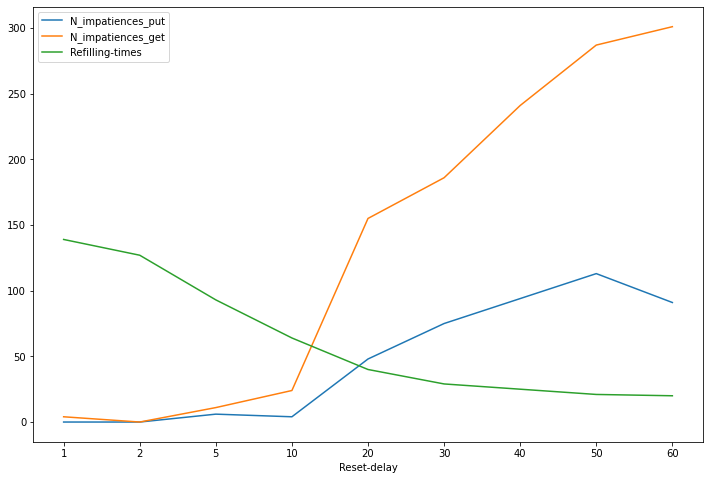

In [52]:
plt.plot(range(0,len(res6)), [row[-1] for row in res6], label='N_impatiences_put')
plt.plot(range(0,len(res6)), [row[-2] for row in res6], label='N_impatiences_get')
plt.plot(range(0,len(res6)), [row[-3] for row in res6], label='Refilling-times')
plt.xticks(range(0,len(res6)), [1,2,5,10,20,30,40,50,60])
plt.xlabel("Reset-delay")
plt.legend(loc='best')
plt.show()